# Fine-tuning - Velocity prediction

We will use the pre-trained StorSeismic model to perform a velocity estimation task. The input and output of the network are adjusted to clean seismic data and their corresponding velocity profile, respectively.

## Load required modules

In [1]:
from transformers import BertConfig, BertForMaskedLM
import transformers
import torch.nn.functional as F
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
import os
import time
from radam import RAdam
import sys
import pandas as pd
import itertools
import torch.nn as nn

from storseismic.modules import *
from storseismic.train import run_velpred
from storseismic.utils import *

pd.set_option('display.max_rows', None)
torch.cuda.empty_cache()

params = {
    'savefig.dpi': 600,  # to adjust notebook inline plot size
    'figure.dpi' : 600,
    'axes.labelsize':14,  # fontsize for x and y labels (was 10)
    'axes.titlesize':14,
    'axes.titleweight': 'bold',
    'legend.fontsize': 14,  # was 10
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

## Initialization

### Fine-tuning configuration

In [2]:
config_path = "./results/pretrain/"
# Allowlist the BertConfig class that appears in the checkpoint
torch.serialization.add_safe_globals([transformers.models.bert.configuration_bert.BertConfig])

config = torch.load(
    os.path.join(config_path, 'config.pt'),
    weights_only=True  # If the file was purely storing module weights
)

# Model Parameter
config.vel_size = 271

# Training Parameter
config.batch_size = 16
config.loss_fn = "l2" # "l2", "ssim", "ssiml1"
config.optim = "radam" # "adam", "radam"
config.lr = 5e-4
config.epoch = 1000
config.warmup = "none" if config.pre_ln else 0
config.patience = 20

# I/O parameter
config.parent_dir = './results/finetune/velpred/'
config.model_path = './results/pretrain/'
config.dataset = './data/finetune/'

config

BertConfig {
  "_attn_implementation_autoset": true,
  "add_alibi": false,
  "add_urpe": false,
  "alibi_type": "nosym",
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "default",
  "batch_size": 16,
  "classifier_dropout": null,
  "dataset": "./data/finetune/",
  "embedding_type": "none",
  "epoch": 1000,
  "fixed": false,
  "fixed_slopes": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "input_type": "trace",
  "intermediate_size": 1024,
  "k": 20,
  "layer_norm_eps": 1e-12,
  "loss_fn": "l2",
  "lr": 0.0005,
  "max_position_embeddings": 20,
  "model_path": "./results/pretrain/",
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_ffn": 4,
  "num_hidden_layers": 4,
  "optim": "radam",
  "output_attentions": true,
  "output_hidden_states": true,
  "output_scores": true,
  "pad_token_id": 0,
  "parent_dir": "./results/finetune/velpred/",
  "patience": 20,
  "position_embedding_type": "sincos",
  

### Load data and wrap in Pytorch DataLoader

In [3]:
config.dataset = './data/finetune/'
train_data = torch.load(
    os.path.join(config.dataset, 'train_data.pt'),
    weights_only=False  # Allows arbitrary pickled code
)
test_data = torch.load(
    os.path.join(config.dataset, 'test_data.pt'),
    weights_only=False
)

vmin_all = -1
vmax_all = 1

config.vel_min = torch.min(train_data.encodings['vel'])
config.vel_max = torch.max(train_data.encodings['vel'])

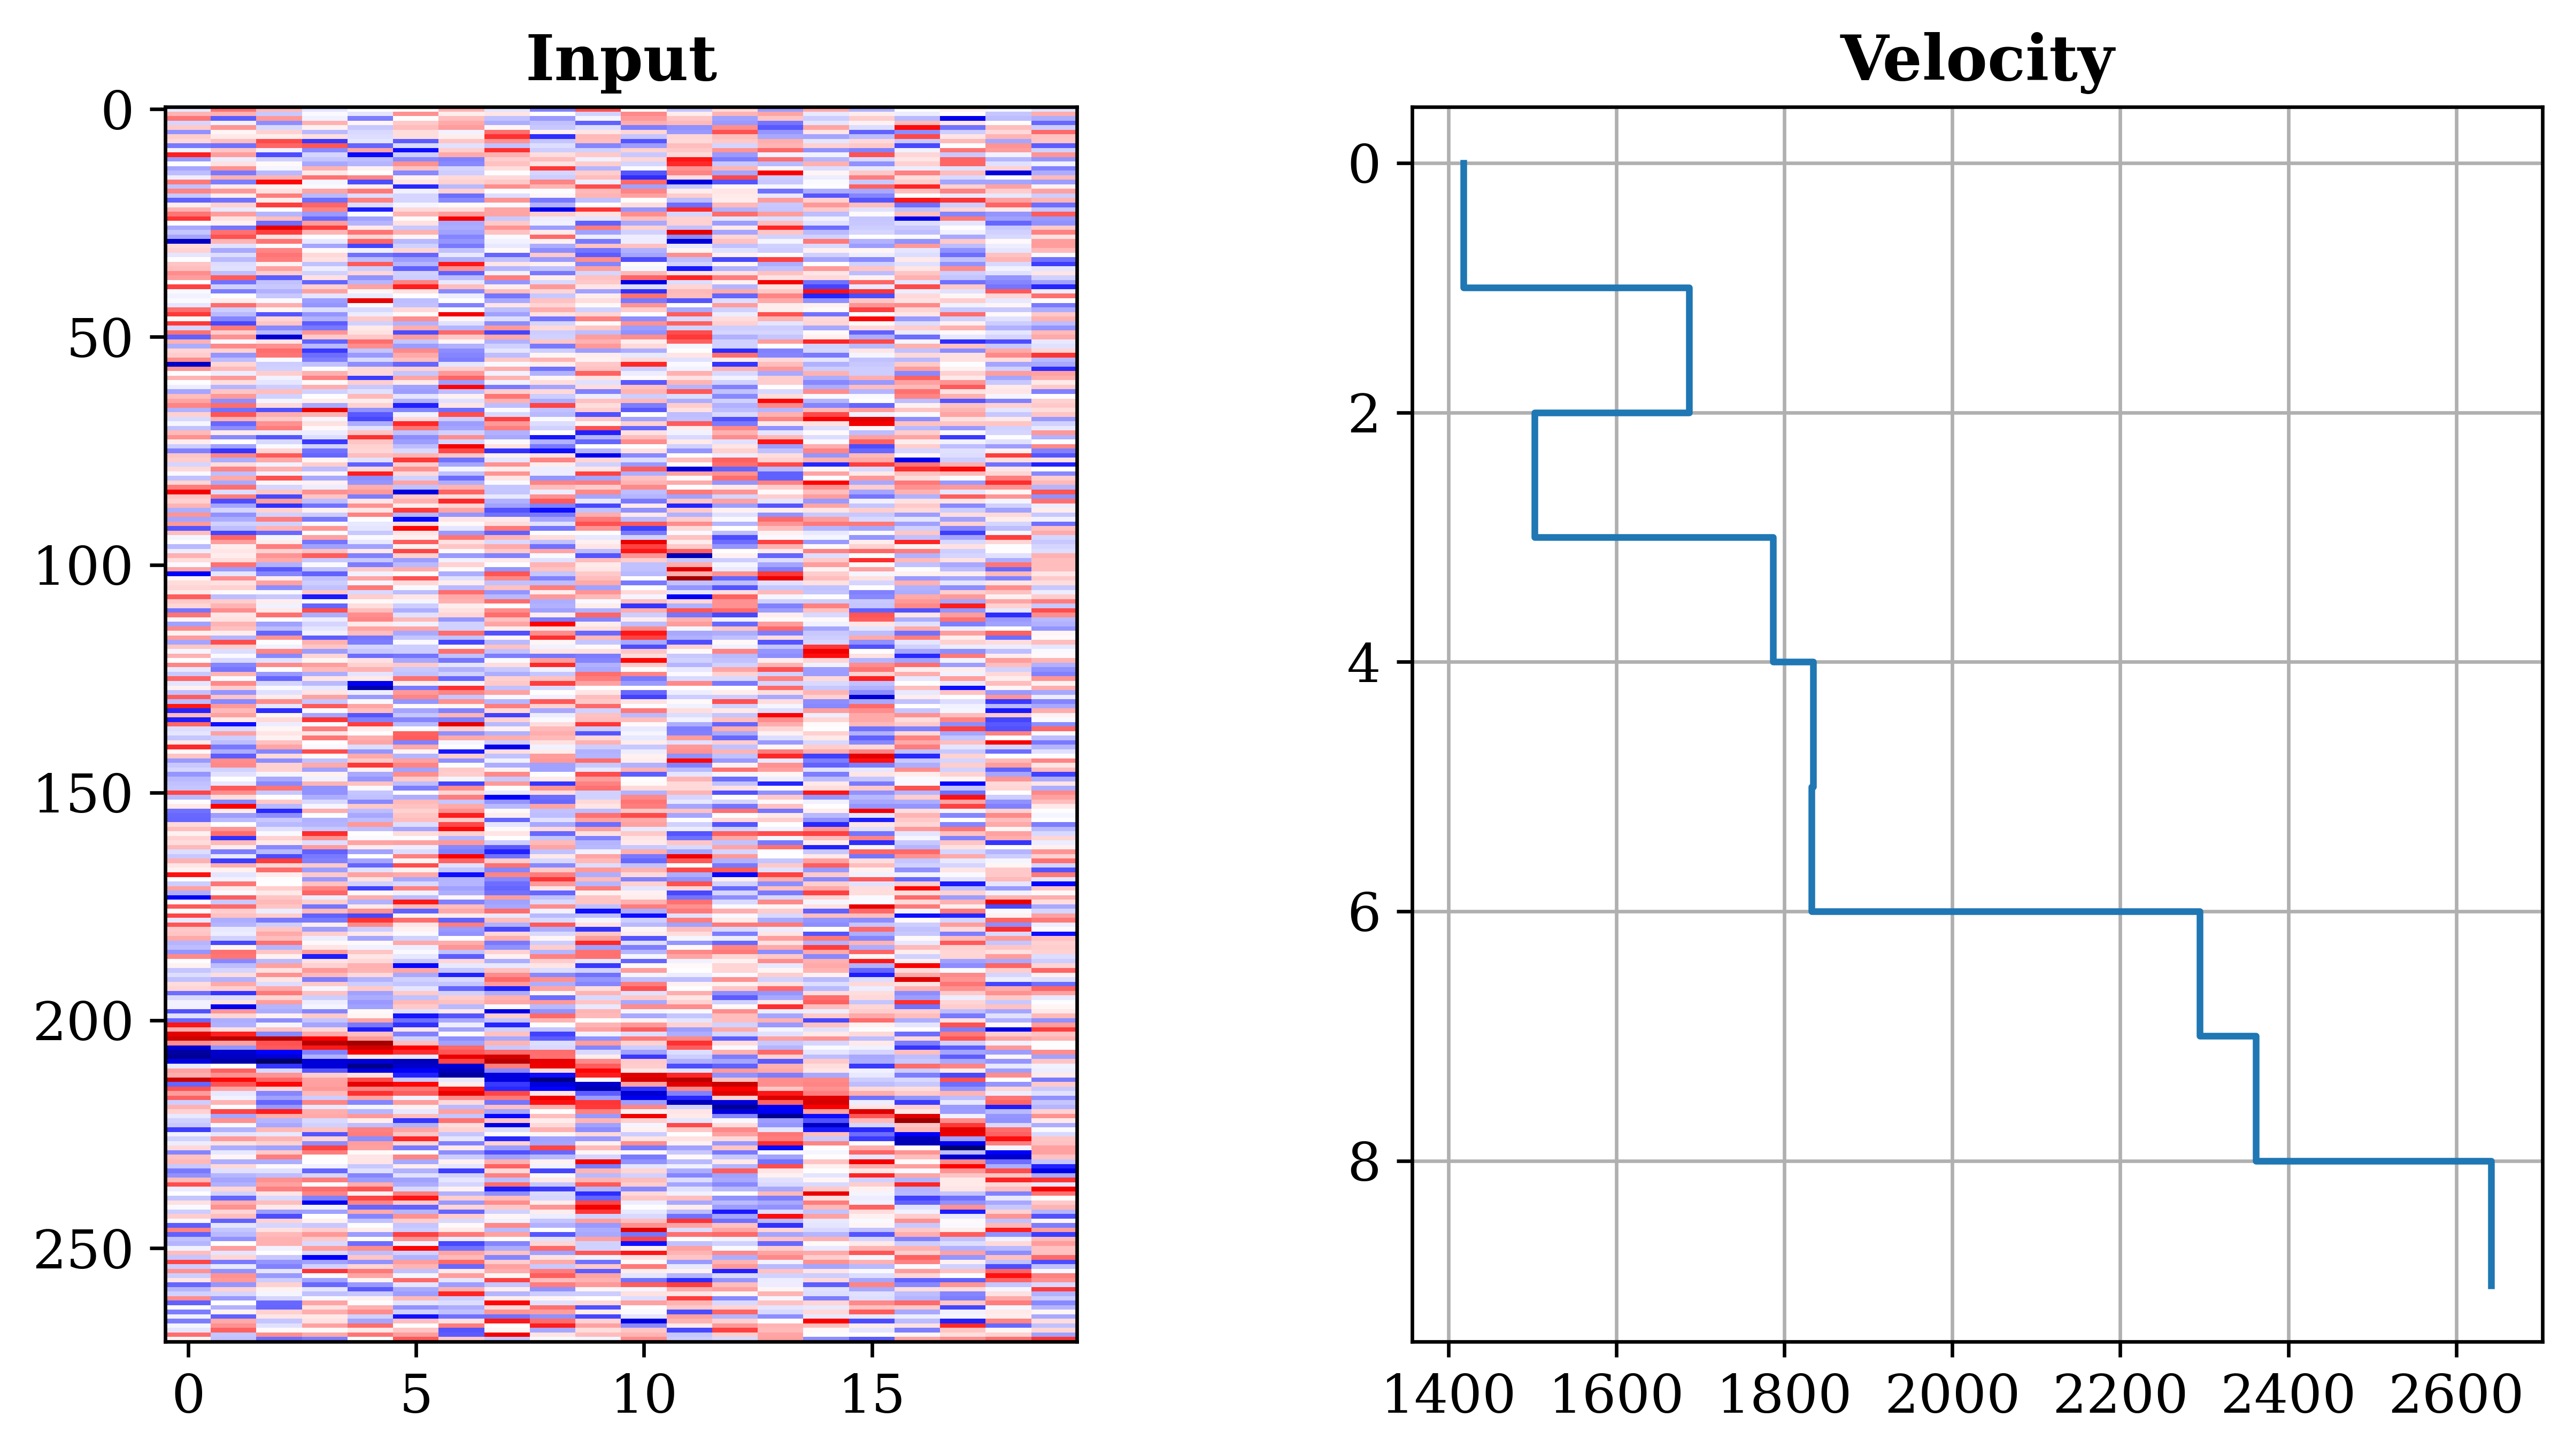

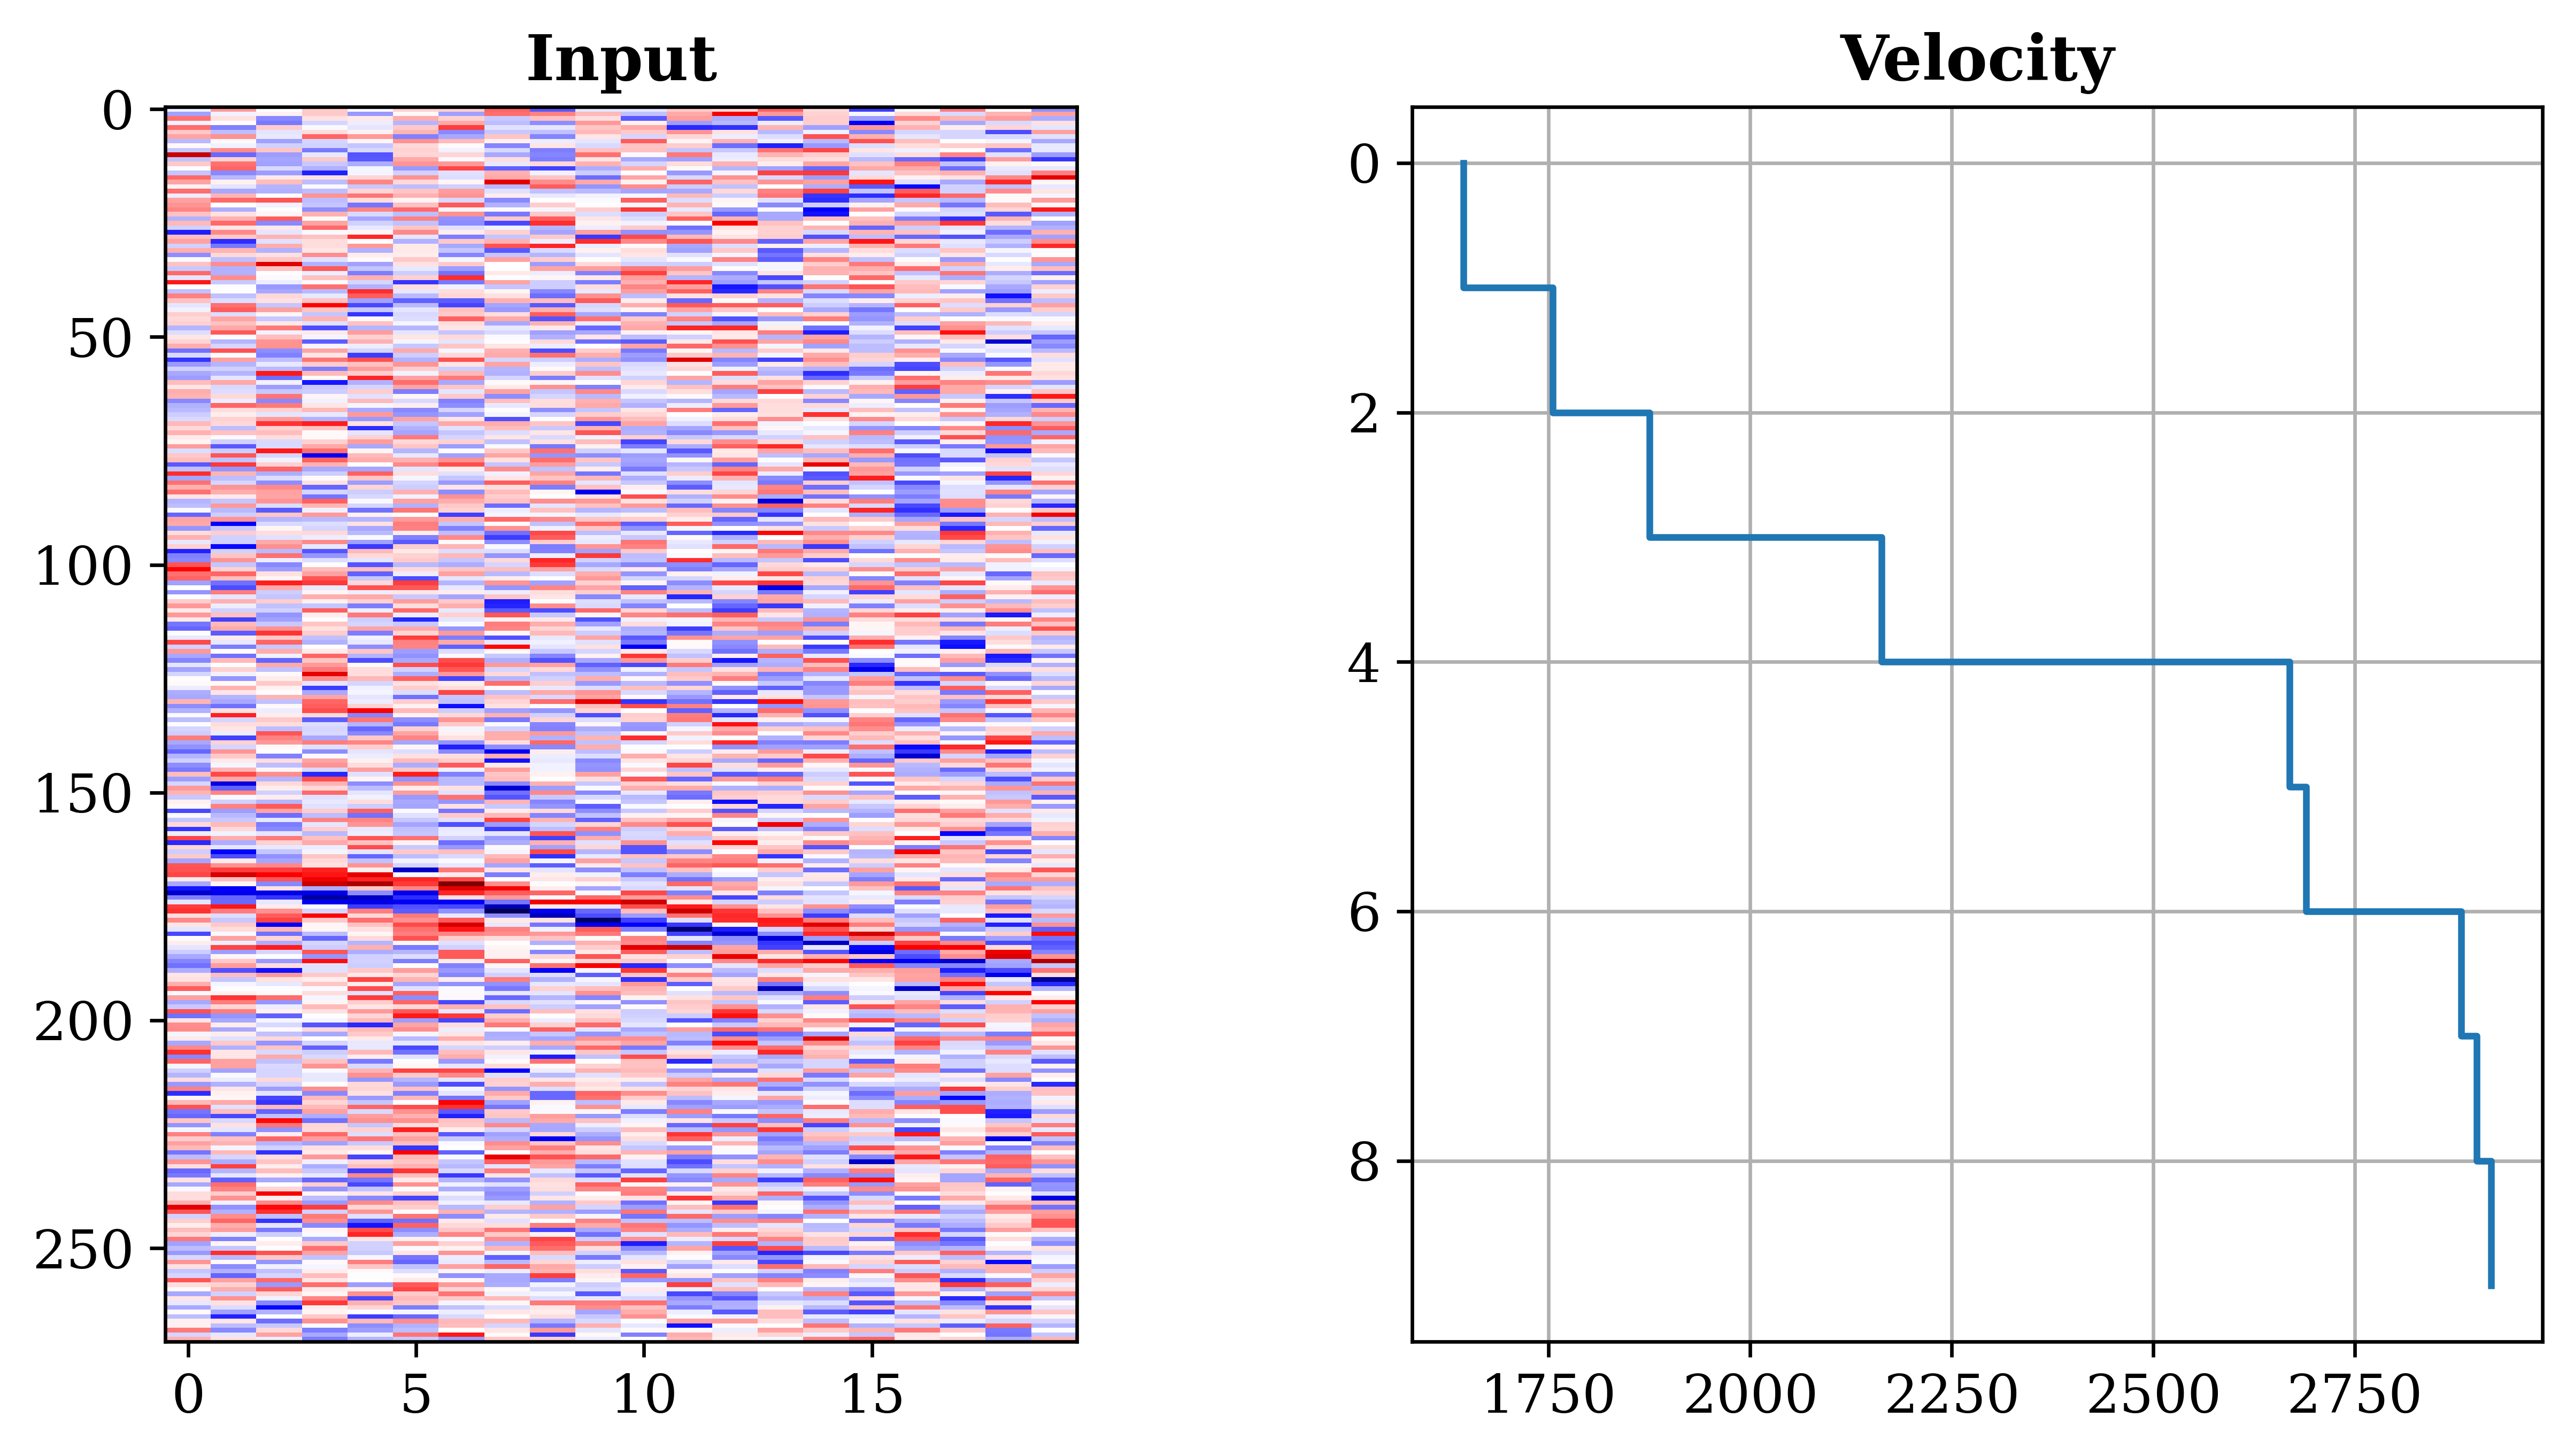

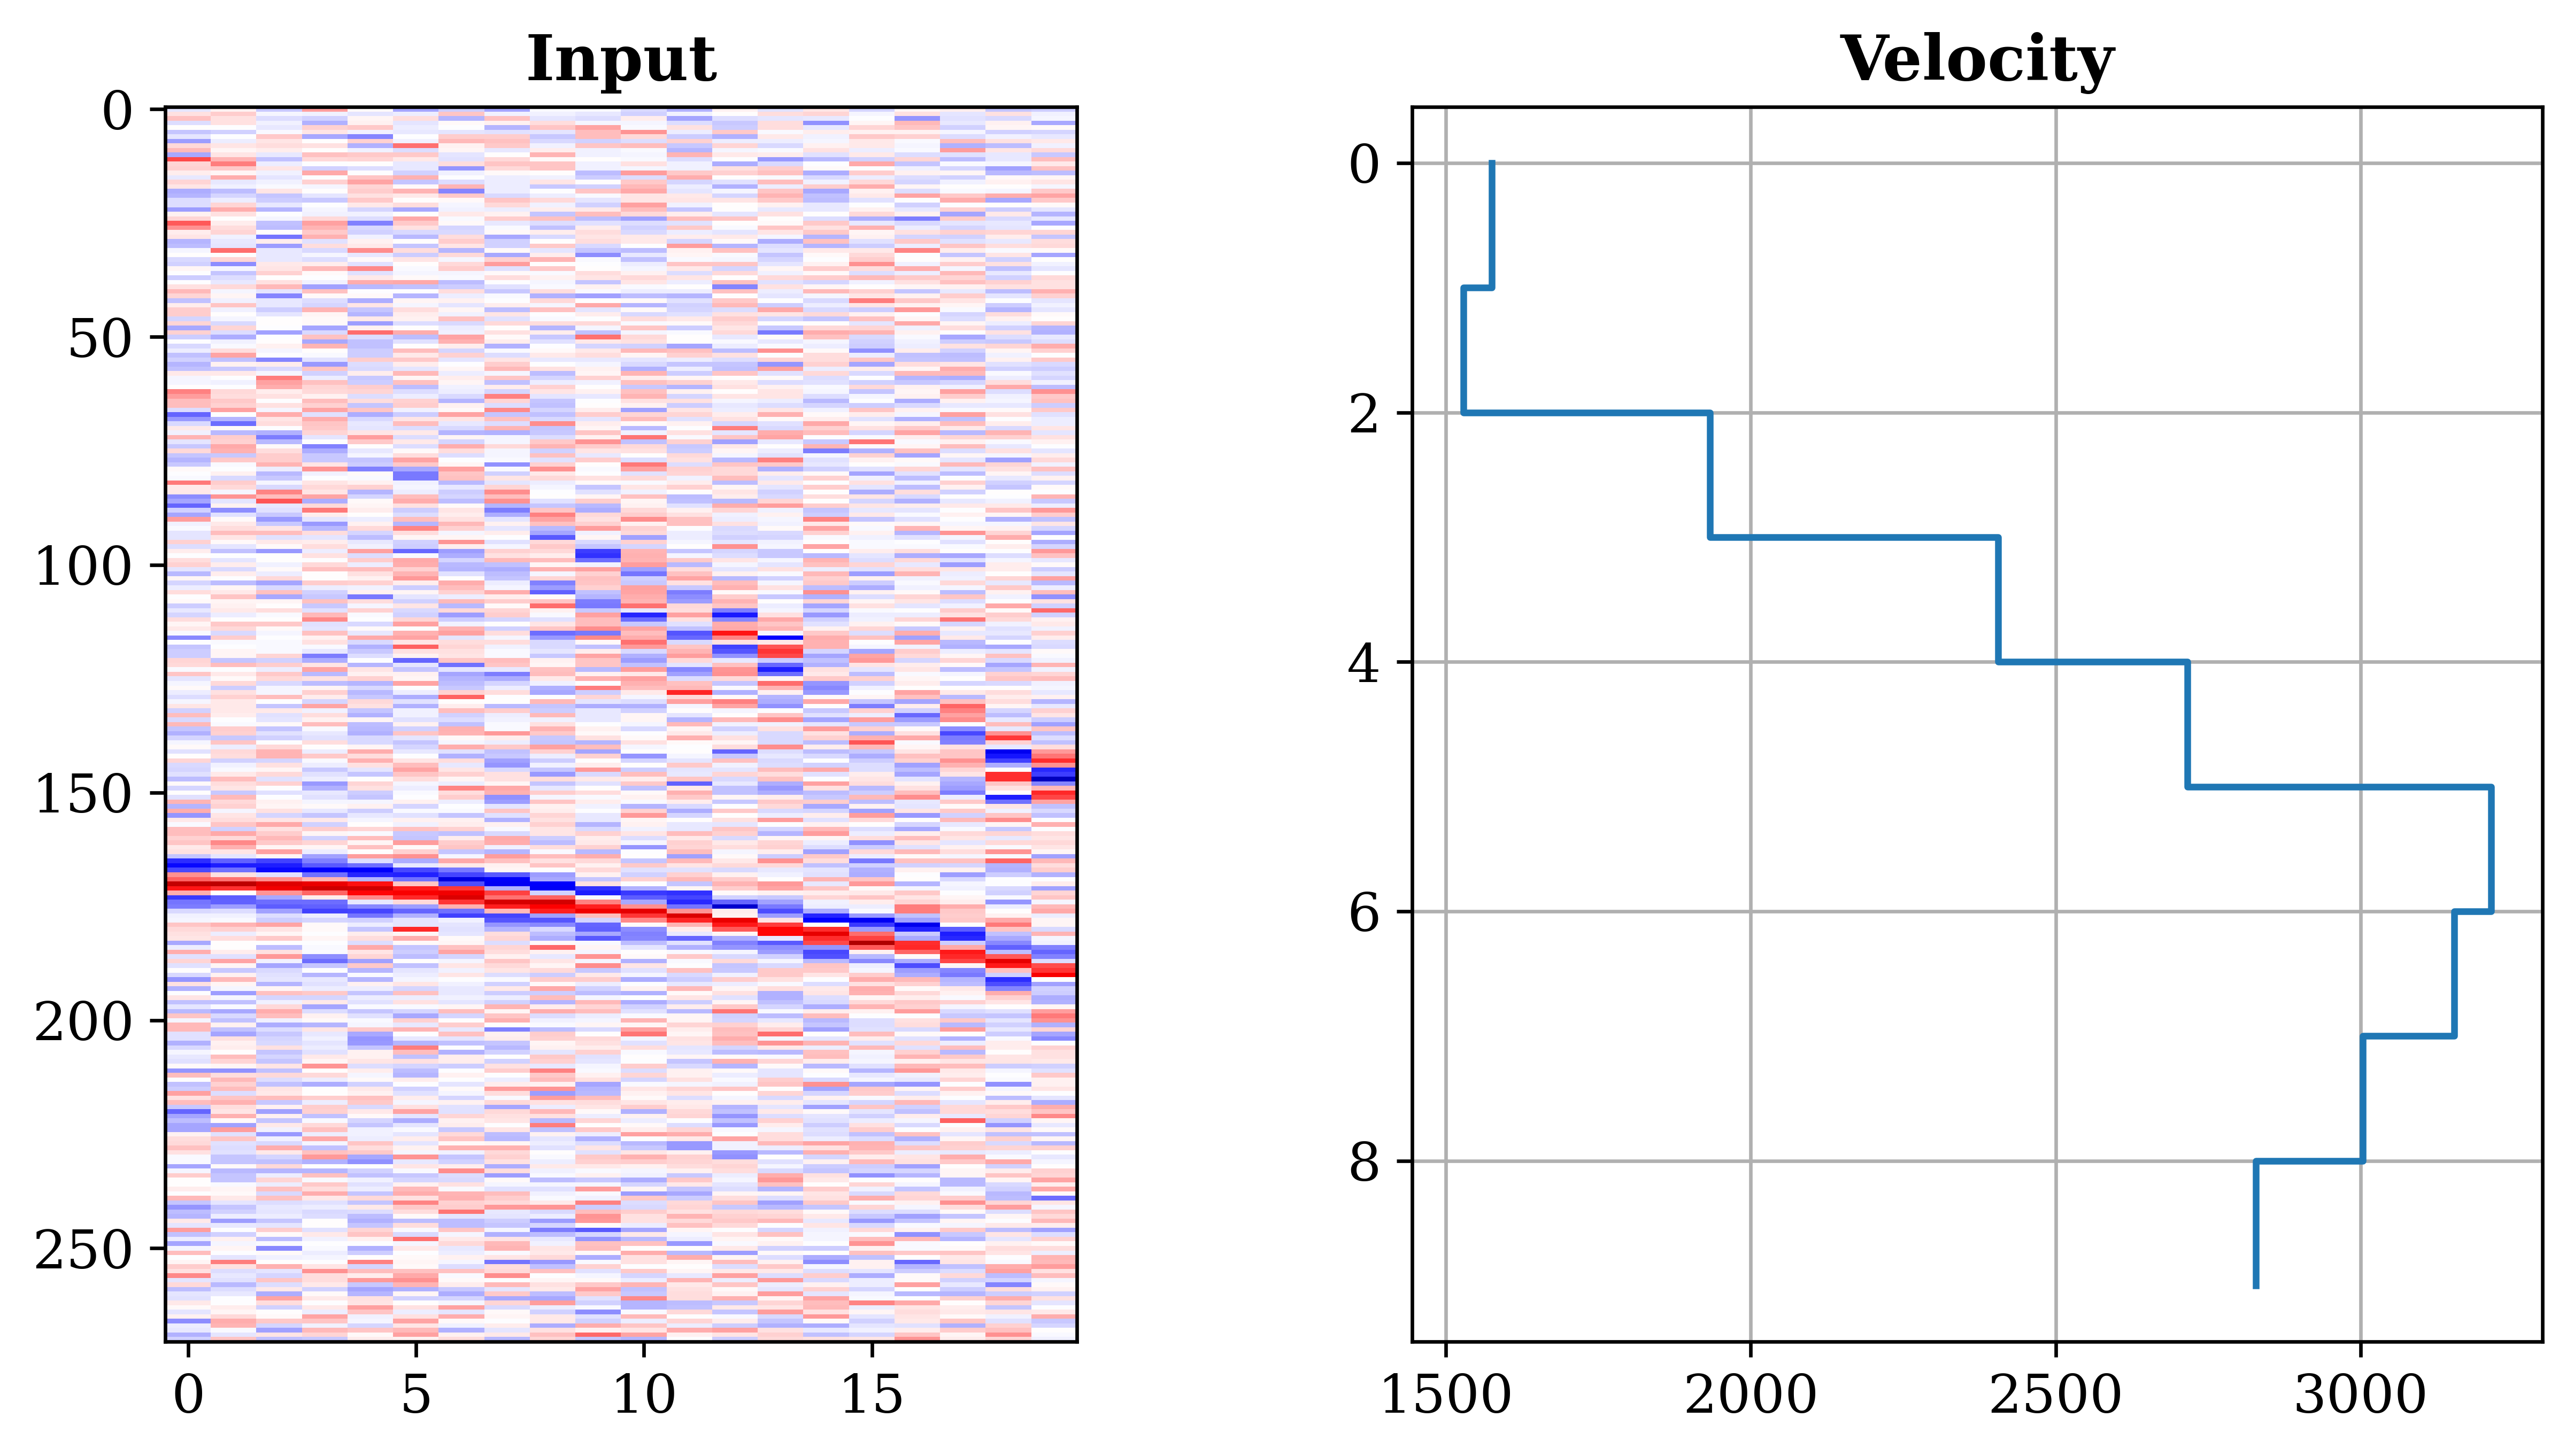

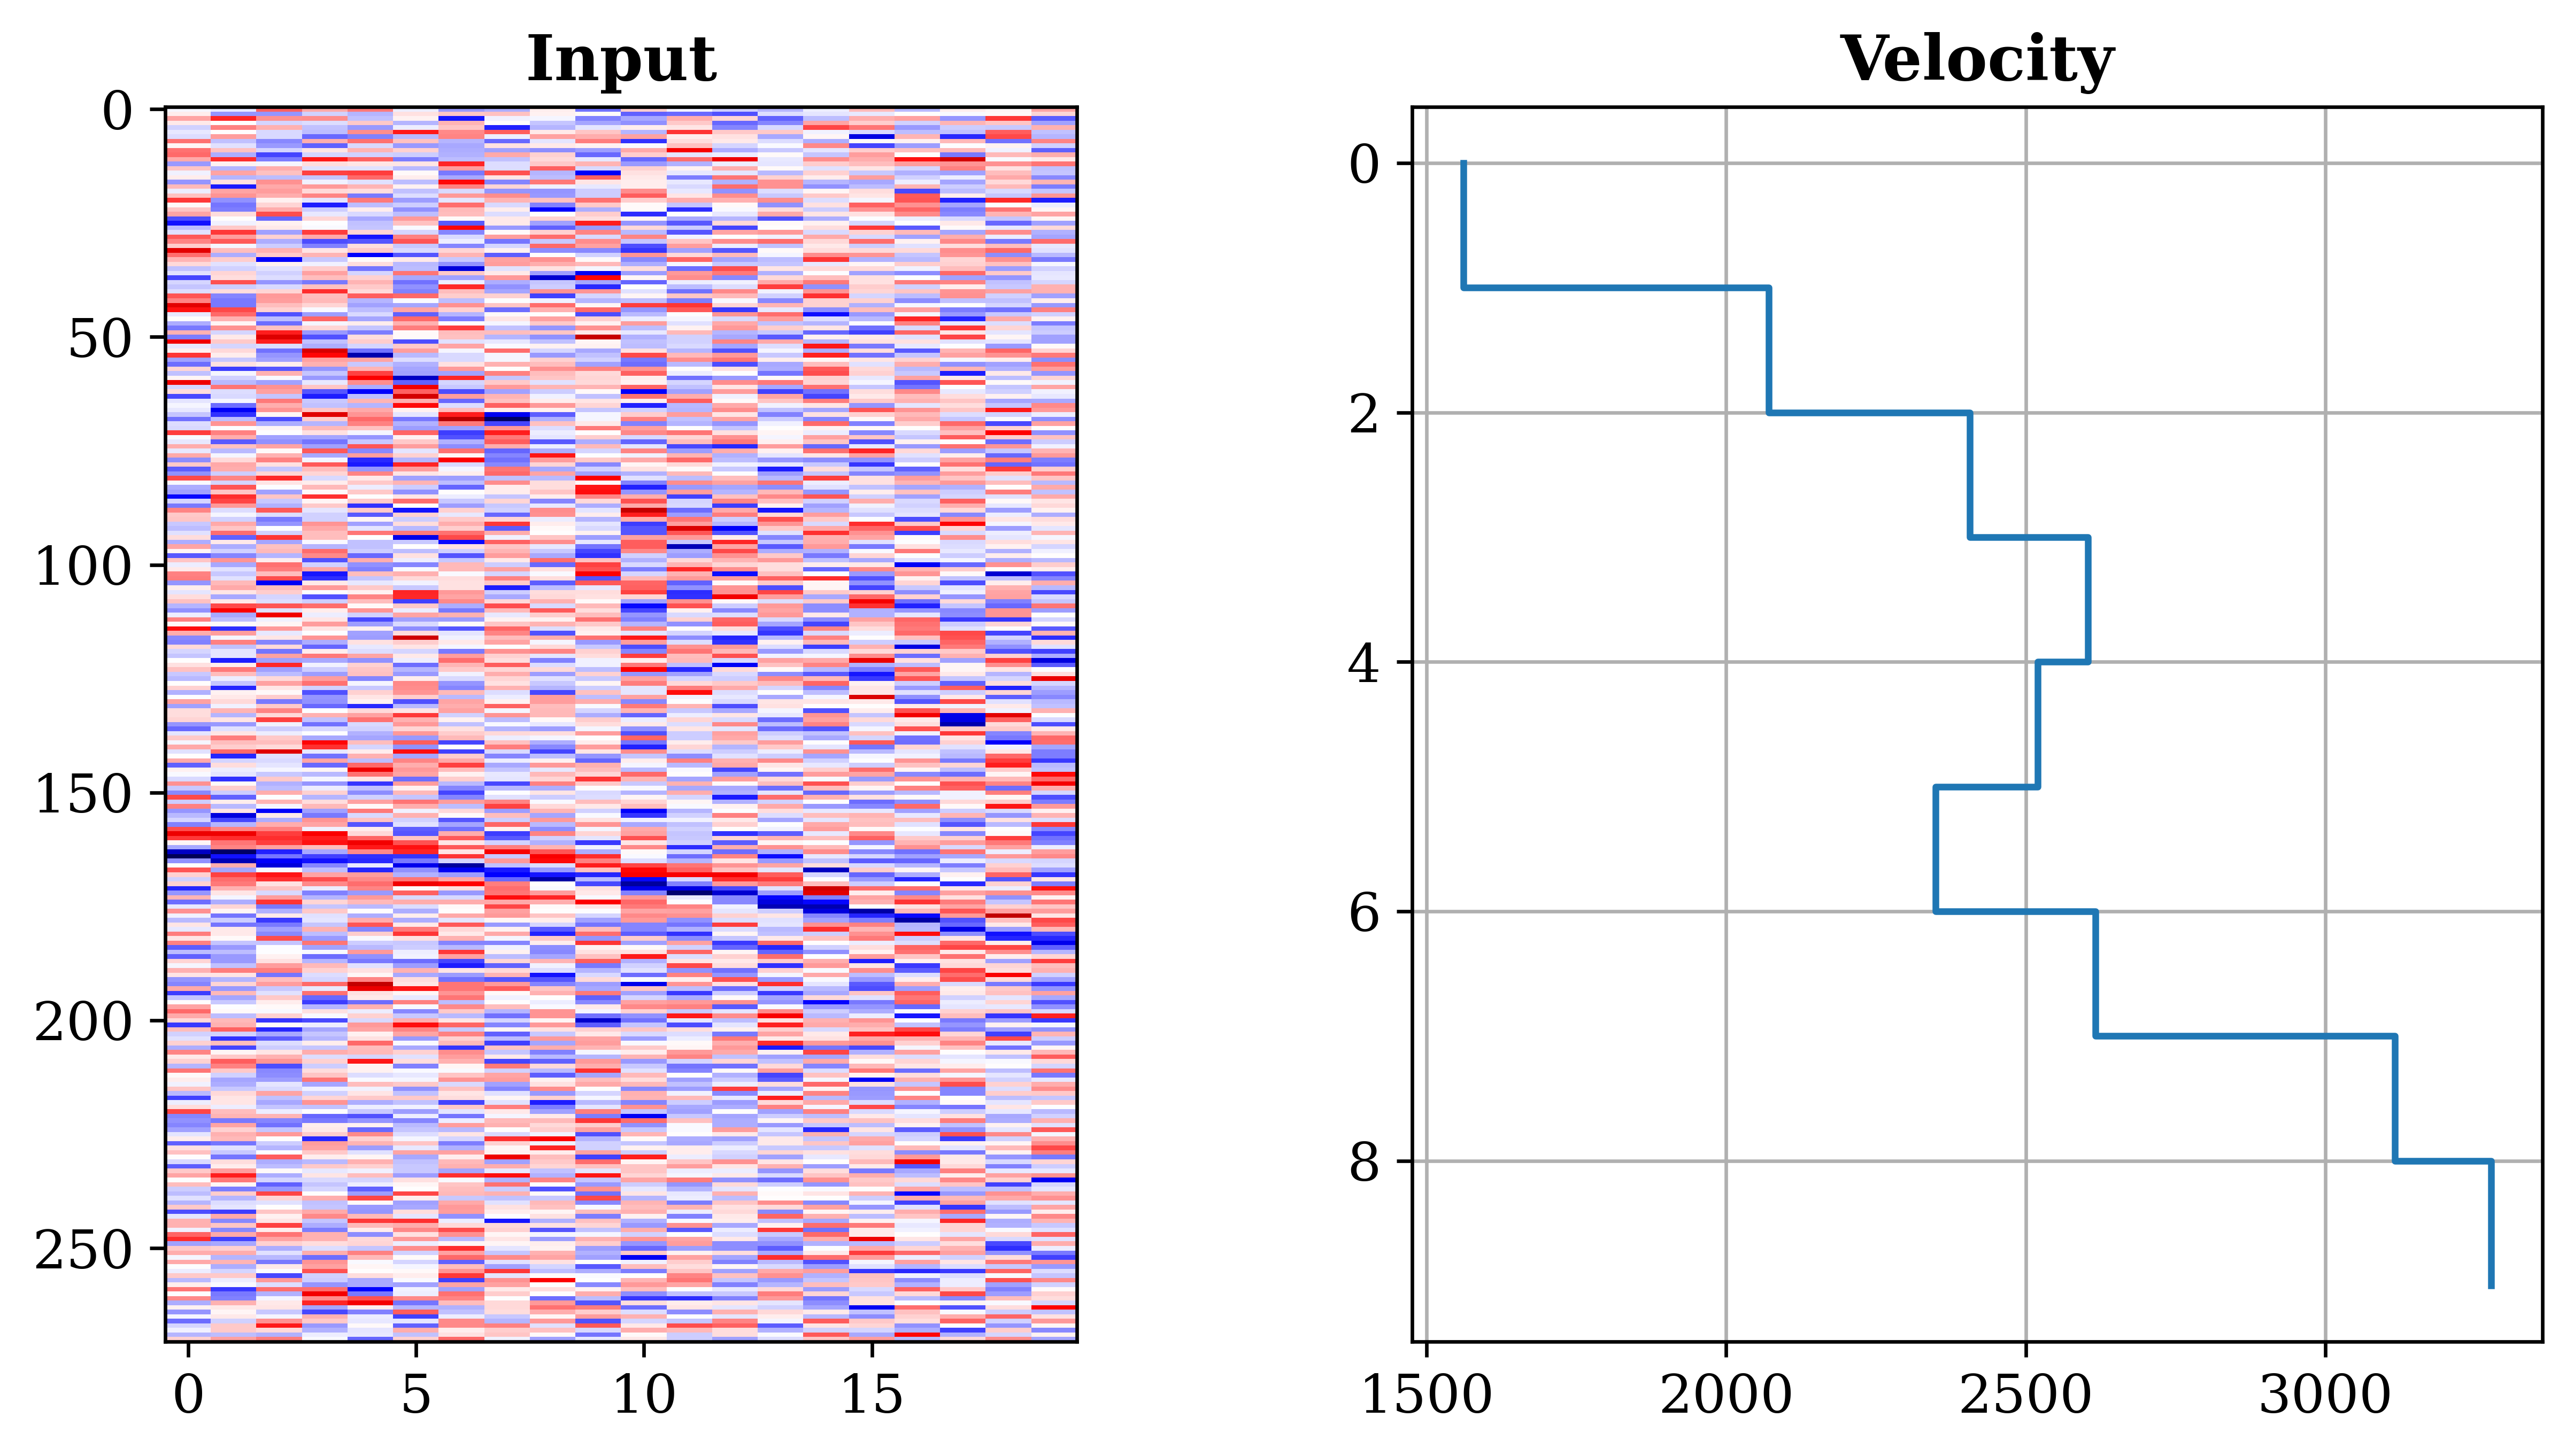

In [4]:
batch_size = config.batch_size

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for i, X in enumerate(train_dataloader):
    if i == 0:
        for j in range(4):
            f, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(X['inputs_embeds'][j, :, :].swapaxes(0, 1) - X['inputs_embeds'][j, :, :].mean(), 
                         aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
            ax[0].set_title("Input")
            ax[1].step(np.pad(X['vel'][j, :], (0, 1), 'edge'), np.arange(X['vel'][j, :].shape[-1] + 1))
            ax[1].invert_yaxis()
            ax[1].set_title("Velocity")
            ax[1].grid()

## Setup StorSeismic velocity prediction model

In [5]:
if not os.path.exists(config.parent_dir):
    os.makedirs(config.parent_dir)

### Load pre-trained model

In [6]:
model = torch.load(os.path.join(config.model_path, "model.pt"), weights_only=False)
print(model)


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(271, 256, padding_idx=0)
      (position_embeddings): Embedding(20, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_features=256, out_features=2

### Change the prediction head

In [7]:
model.cls = VelpredHead(config)
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(271, 256, padding_idx=0)
      (position_embeddings): Embedding(20, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_features=256, out_features=2

### Check number of trainable parameters

In [8]:
def count_parameters(model):
    table = pd.DataFrame(columns=['Name', 'Parameter'])
    total_params = 0
    i = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params+=param
        table.loc[i] = [name] + [param]
        i += 1
    display(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

,Name,Parameter
0,bert.embeddings.word_embeddings.weight,69376
1,bert.embeddings.position_embeddings.weight,5120
2,bert.embeddings.token_type_embeddings.weight,512
3,bert.embeddings.LayerNorm.weight,256
4,bert.embeddings.LayerNorm.bias,256
5,bert.encoder.layer.0.attention.LayerNorm.weight,256
6,bert.encoder.layer.0.attention.LayerNorm.bias,256
7,bert.encoder.layer.0.attention.self.query.weight,65536
8,bert.encoder.layer.0.attention.self.query.bias,256
9,bert.encoder.layer.0.attention.self.key.weight,65536


Total Trainable Params: 3304207


3304207

#### Send model to device

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Using device: {}".format(device))

Using device: cuda


## Training

### Set up training hyperparameters

In [10]:
# Optimizer
optim = RAdam(model.parameters(), lr=config.lr)

# Loss
loss_fn = nn.L1Loss()

# Number of epochs
epochs = config.epoch

### Train

In [11]:
%matplotlib notebook

plt.ion()
f, ax = plt.subplots(figsize=(4, 3))

<IPython.core.display.Javascript object>

In [12]:
print(train_dataloader)

In [13]:
# First, create proper matplotlib figure and axis objects
%matplotlib notebook
plt.ion()
fig, ax = plt.subplots(figsize=(4, 3))

# Define the projection: mapping from the velocity input size (271) to the model's hidden size (256)
projection = nn.Linear(271, 256).to(device)

# Initialize the model's velocity prediction head to output values around 2000 m/s
with torch.no_grad():
    # Get the bias of the prediction layer and set it to a value that would output ~2000 m/s
    if hasattr(model.cls.predictions, 'bias'):
        # Initialize to constant value around 2000
        model.cls.predictions.bias.fill_(2000.0)
    # You might also want to initialize the weights to small values
    if hasattr(model.cls.predictions, 'weight'):
        nn.init.normal_(model.cls.predictions.weight, mean=0.0, std=0.01)

model, avg_train_loss, avg_valid_loss, time_per_epoch = run_velpred(
    model, optim, loss_fn, train_dataloader, test_dataloader, config.vel_size, epochs, device,
    tmp_dir=config.parent_dir, patience=config.patience, plot=True, f=fig, ax=ax,
    projection=projection
    )

%matplotlib inline
plt.ioff()

<IPython.core.display.Javascript object>

  0%|          | 0/75 [00:00<?, ?it/s]/home/masa/miniconda3/envs/storseismic/lib/python3.13/site-packages/radam/radam.py:58: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1661.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
Validation 0: 100%|██████████| 19/19 [00:00<00:00, 599.40it/s, loss=2.99e+6]


Epoch time: 0.69 s
Total time elapsed: 0.69 s
---------------------------------------
Validation loss decreased (inf --> 2989959.973684).  Saving model ...


Validation 1: 100%|██████████| 19/19 [00:00<00:00, 486.40it/s, loss=1.92e+6]


Epoch time: 0.48 s
Total time elapsed: 1.28 s
---------------------------------------
Validation loss decreased (2989959.973684 --> 1908733.013158).  Saving model ...


Validation 2: 100%|██████████| 19/19 [00:00<00:00, 461.08it/s, loss=8.39e+4]


Epoch time: 0.51 s
Total time elapsed: 1.91 s
---------------------------------------
Validation loss decreased (1908733.013158 --> 63435.307977).  Saving model ...


Validation 3: 100%|██████████| 19/19 [00:00<00:00, 577.69it/s, loss=6.5e+4]


Epoch time: 0.43 s
Total time elapsed: 2.46 s
---------------------------------------
Validation loss decreased (63435.307977 --> 57703.204564).  Saving model ...


Validation 4: 100%|██████████| 19/19 [00:00<00:00, 469.05it/s, loss=3.71e+4]


Epoch time: 0.44 s
Total time elapsed: 3.03 s
---------------------------------------
Validation loss decreased (57703.204564 --> 53562.870271).  Saving model ...


Validation 5: 100%|██████████| 19/19 [00:00<00:00, 488.27it/s, loss=5.93e+4]


Epoch time: 0.49 s
Total time elapsed: 3.63 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 6: 100%|██████████| 19/19 [00:00<00:00, 531.31it/s, loss=7.54e+4]


Epoch time: 0.46 s
Total time elapsed: 4.20 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 7: 100%|██████████| 19/19 [00:00<00:00, 478.20it/s, loss=9.28e+4]


Epoch time: 0.47 s
Total time elapsed: 4.77 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 8: 100%|██████████| 19/19 [00:00<00:00, 506.17it/s, loss=5.65e+4]


Epoch time: 0.42 s
Total time elapsed: 5.30 s
---------------------------------------
Validation loss decreased (53562.870271 --> 51773.161595).  Saving model ...


Validation 9: 100%|██████████| 19/19 [00:00<00:00, 549.14it/s, loss=6.51e+4]


Epoch time: 0.43 s
Total time elapsed: 5.85 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 10: 100%|██████████| 19/19 [00:00<00:00, 582.97it/s, loss=4.83e+4]


Epoch time: 0.47 s
Total time elapsed: 6.42 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 11: 100%|██████████| 19/19 [00:00<00:00, 577.32it/s, loss=4.86e+4]


Epoch time: 0.45 s
Total time elapsed: 6.97 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 12: 100%|██████████| 19/19 [00:00<00:00, 529.09it/s, loss=7.09e+4]


Epoch time: 0.43 s
Total time elapsed: 7.50 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 13: 100%|██████████| 19/19 [00:00<00:00, 492.82it/s, loss=7.31e+4]


Epoch time: 0.44 s
Total time elapsed: 8.05 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 14: 100%|██████████| 19/19 [00:00<00:00, 589.03it/s, loss=5.56e+4]


Epoch time: 0.43 s
Total time elapsed: 8.59 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 15: 100%|██████████| 19/19 [00:00<00:00, 551.80it/s, loss=6.43e+4]


Epoch time: 0.47 s
Total time elapsed: 9.16 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 16: 100%|██████████| 19/19 [00:00<00:00, 559.57it/s, loss=7.07e+4]


Epoch time: 0.44 s
Total time elapsed: 9.70 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 17: 100%|██████████| 19/19 [00:00<00:00, 509.53it/s, loss=5.98e+4]


Epoch time: 0.46 s
Total time elapsed: 10.25 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 18: 100%|██████████| 19/19 [00:00<00:00, 608.70it/s, loss=6.84e+4]


Epoch time: 0.42 s
Total time elapsed: 10.77 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 19: 100%|██████████| 19/19 [00:00<00:00, 614.46it/s, loss=3.6e+4]


Epoch time: 0.42 s
Total time elapsed: 11.29 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 20: 100%|██████████| 19/19 [00:00<00:00, 576.12it/s, loss=4.56e+4]


Epoch time: 0.48 s
Total time elapsed: 11.87 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 21: 100%|██████████| 19/19 [00:00<00:00, 552.33it/s, loss=5.62e+4]


Epoch time: 0.43 s
Total time elapsed: 12.40 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 22: 100%|██████████| 19/19 [00:00<00:00, 567.06it/s, loss=8.11e+4]


Epoch time: 0.44 s
Total time elapsed: 12.93 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 23: 100%|██████████| 19/19 [00:00<00:00, 556.71it/s, loss=4.6e+4]


Epoch time: 0.46 s
Total time elapsed: 13.52 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 24: 100%|██████████| 19/19 [00:00<00:00, 498.83it/s, loss=4.79e+4]


Epoch time: 0.45 s
Total time elapsed: 14.06 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 25: 100%|██████████| 19/19 [00:00<00:00, 568.84it/s, loss=5.5e+4]


Epoch time: 0.45 s
Total time elapsed: 14.62 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 26: 100%|██████████| 19/19 [00:00<00:00, 534.93it/s, loss=5.88e+4]


Epoch time: 0.46 s
Total time elapsed: 15.19 s
---------------------------------------
EarlyStopping counter: 18 out of 20


Validation 27: 100%|██████████| 19/19 [00:00<00:00, 596.71it/s, loss=7.2e+4]


Epoch time: 0.51 s
Total time elapsed: 15.79 s
---------------------------------------
EarlyStopping counter: 19 out of 20


Validation 28: 100%|██████████| 19/19 [00:00<00:00, 475.31it/s, loss=8.48e+4]


Epoch time: 0.50 s
Total time elapsed: 16.39 s
---------------------------------------
EarlyStopping counter: 20 out of 20
Early stopping


In [14]:
from transformers.modeling_outputs import BaseModelOutputWithPoolingAndCrossAttentions

# Define the projection: mapping from the velocity input size (271) to the model's hidden size (256)
projection = nn.Linear(271, 256).to(device)

model, avg_train_loss, avg_valid_loss, time_per_epoch = run_velpred(
    model, optim, loss_fn, train_dataloader, test_dataloader, config.vel_size, epochs, device,
    tmp_dir=config.parent_dir, patience=config.patience, plot=True, f=f, ax=ax,
    projection=projection
    )

%matplotlib inline
plt.ioff()

Validation 0: 100%|██████████| 19/19 [00:00<00:00, 516.40it/s, loss=4.8e+4]


Epoch time: 0.49 s
Total time elapsed: 0.49 s
---------------------------------------
Validation loss decreased (inf --> 54395.924753).  Saving model ...


Validation 1: 100%|██████████| 19/19 [00:00<00:00, 498.70it/s, loss=5.81e+4]


Epoch time: 0.46 s
Total time elapsed: 0.98 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 2: 100%|██████████| 19/19 [00:00<00:00, 610.15it/s, loss=5.15e+4]


Epoch time: 0.51 s
Total time elapsed: 1.50 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 3: 100%|██████████| 19/19 [00:00<00:00, 424.10it/s, loss=5.52e+4]


Epoch time: 0.46 s
Total time elapsed: 1.98 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 4: 100%|██████████| 19/19 [00:00<00:00, 593.94it/s, loss=5.51e+4]


Epoch time: 0.42 s
Total time elapsed: 2.42 s
---------------------------------------
Validation loss decreased (54395.924753 --> 54392.692434).  Saving model ...


Validation 5: 100%|██████████| 19/19 [00:00<00:00, 576.58it/s, loss=6.66e+4]


Epoch time: 0.47 s
Total time elapsed: 2.93 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 6: 100%|██████████| 19/19 [00:00<00:00, 586.34it/s, loss=6.27e+4]


Epoch time: 0.46 s
Total time elapsed: 3.40 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 7: 100%|██████████| 19/19 [00:00<00:00, 565.58it/s, loss=6.11e+4]


Epoch time: 0.42 s
Total time elapsed: 3.84 s
---------------------------------------
Validation loss decreased (54392.692434 --> 50592.364104).  Saving model ...


Validation 8: 100%|██████████| 19/19 [00:00<00:00, 573.81it/s, loss=4.92e+4]


Epoch time: 0.42 s
Total time elapsed: 4.30 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 9: 100%|██████████| 19/19 [00:00<00:00, 584.28it/s, loss=7.84e+4]


Epoch time: 0.44 s
Total time elapsed: 4.75 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 10: 100%|██████████| 19/19 [00:00<00:00, 637.20it/s, loss=3.11e+4]


Epoch time: 0.41 s
Total time elapsed: 5.18 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 11: 100%|██████████| 19/19 [00:00<00:00, 533.42it/s, loss=6.3e+4]


Epoch time: 0.43 s
Total time elapsed: 5.63 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 12: 100%|██████████| 19/19 [00:00<00:00, 570.37it/s, loss=4.33e+4]


Epoch time: 0.47 s
Total time elapsed: 6.12 s
---------------------------------------
Validation loss decreased (50592.364104 --> 50358.881579).  Saving model ...


Validation 13: 100%|██████████| 19/19 [00:00<00:00, 626.61it/s, loss=8.44e+4]


Epoch time: 0.42 s
Total time elapsed: 6.73 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 14: 100%|██████████| 19/19 [00:00<00:00, 560.40it/s, loss=4.08e+4]


Epoch time: 0.44 s
Total time elapsed: 7.19 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 15: 100%|██████████| 19/19 [00:00<00:00, 573.50it/s, loss=5.13e+4]


Epoch time: 0.48 s
Total time elapsed: 7.68 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 16: 100%|██████████| 19/19 [00:00<00:00, 548.31it/s, loss=3.7e+4]


Epoch time: 0.48 s
Total time elapsed: 8.18 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 17: 100%|██████████| 19/19 [00:00<00:00, 555.58it/s, loss=5.98e+4]


Epoch time: 0.48 s
Total time elapsed: 8.68 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 18: 100%|██████████| 19/19 [00:00<00:00, 585.38it/s, loss=7.25e+4]


Epoch time: 0.43 s
Total time elapsed: 9.13 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 19: 100%|██████████| 19/19 [00:00<00:00, 515.51it/s, loss=4.22e+4]


Epoch time: 0.44 s
Total time elapsed: 9.58 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 20: 100%|██████████| 19/19 [00:00<00:00, 570.67it/s, loss=3.28e+4]


Epoch time: 0.43 s
Total time elapsed: 10.03 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 21: 100%|██████████| 19/19 [00:00<00:00, 610.43it/s, loss=5.29e+4]


Epoch time: 0.43 s
Total time elapsed: 10.47 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 22: 100%|██████████| 19/19 [00:00<00:00, 576.39it/s, loss=5.93e+4]


Epoch time: 0.45 s
Total time elapsed: 10.93 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 23: 100%|██████████| 19/19 [00:00<00:00, 557.78it/s, loss=3.45e+4]


Epoch time: 0.42 s
Total time elapsed: 11.37 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 24: 100%|██████████| 19/19 [00:00<00:00, 598.51it/s, loss=6.11e+4]


Epoch time: 0.43 s
Total time elapsed: 11.81 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 25: 100%|██████████| 19/19 [00:00<00:00, 589.51it/s, loss=4.9e+4]


Epoch time: 0.45 s
Total time elapsed: 12.27 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 26: 100%|██████████| 19/19 [00:00<00:00, 609.26it/s, loss=4.63e+4]


Epoch time: 0.44 s
Total time elapsed: 12.72 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 27: 100%|██████████| 19/19 [00:00<00:00, 570.31it/s, loss=3.91e+4]


Epoch time: 0.43 s
Total time elapsed: 13.17 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 28: 100%|██████████| 19/19 [00:00<00:00, 578.93it/s, loss=5.27e+4]


Epoch time: 0.46 s
Total time elapsed: 13.64 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 29: 100%|██████████| 19/19 [00:00<00:00, 561.77it/s, loss=4.74e+4]


Epoch time: 0.44 s
Total time elapsed: 14.09 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 30: 100%|██████████| 19/19 [00:00<00:00, 572.08it/s, loss=6.11e+4]


Epoch time: 0.44 s
Total time elapsed: 14.54 s
---------------------------------------
Validation loss decreased (50358.881579 --> 49645.938734).  Saving model ...


Validation 31: 100%|██████████| 19/19 [00:00<00:00, 633.41it/s, loss=7.16e+4]


Epoch time: 0.41 s
Total time elapsed: 14.99 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 32: 100%|██████████| 19/19 [00:00<00:00, 602.69it/s, loss=6.71e+4]


Epoch time: 0.42 s
Total time elapsed: 15.42 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 33: 100%|██████████| 19/19 [00:00<00:00, 615.41it/s, loss=6.1e+4]


Epoch time: 0.45 s
Total time elapsed: 15.89 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 34: 100%|██████████| 19/19 [00:00<00:00, 572.99it/s, loss=4.15e+4]


Epoch time: 0.44 s
Total time elapsed: 16.34 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 35: 100%|██████████| 19/19 [00:00<00:00, 459.29it/s, loss=6.02e+4]


Epoch time: 0.44 s
Total time elapsed: 16.79 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 36: 100%|██████████| 19/19 [00:00<00:00, 596.51it/s, loss=5.38e+4]


Epoch time: 0.46 s
Total time elapsed: 17.27 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 37: 100%|██████████| 19/19 [00:00<00:00, 567.79it/s, loss=6.3e+4]


Epoch time: 0.43 s
Total time elapsed: 17.71 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 38: 100%|██████████| 19/19 [00:00<00:00, 582.97it/s, loss=9.82e+4]


Epoch time: 0.45 s
Total time elapsed: 18.18 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 39: 100%|██████████| 19/19 [00:00<00:00, 637.46it/s, loss=6.96e+4]


Epoch time: 0.41 s
Total time elapsed: 18.61 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 40: 100%|██████████| 19/19 [00:00<00:00, 581.19it/s, loss=6.86e+4]


Epoch time: 0.41 s
Total time elapsed: 19.03 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 41: 100%|██████████| 19/19 [00:00<00:00, 602.13it/s, loss=5.93e+4]


Epoch time: 0.47 s
Total time elapsed: 19.51 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 42: 100%|██████████| 19/19 [00:00<00:00, 633.87it/s, loss=6.1e+4]


Epoch time: 0.42 s
Total time elapsed: 19.95 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 43: 100%|██████████| 19/19 [00:00<00:00, 459.84it/s, loss=3.92e+4]


Epoch time: 0.43 s
Total time elapsed: 20.39 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 44: 100%|██████████| 19/19 [00:00<00:00, 574.91it/s, loss=7e+4]


Epoch time: 0.44 s
Total time elapsed: 20.85 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 45: 100%|██████████| 19/19 [00:00<00:00, 545.44it/s, loss=6.6e+4]


Epoch time: 0.52 s
Total time elapsed: 21.38 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 46: 100%|██████████| 19/19 [00:00<00:00, 576.47it/s, loss=5.86e+4]


Epoch time: 0.43 s
Total time elapsed: 21.83 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 47: 100%|██████████| 19/19 [00:00<00:00, 430.77it/s, loss=5.16e+4]


Epoch time: 0.46 s
Total time elapsed: 22.30 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 48: 100%|██████████| 19/19 [00:00<00:00, 617.13it/s, loss=5.24e+4]


Epoch time: 0.47 s
Total time elapsed: 22.79 s
---------------------------------------
EarlyStopping counter: 18 out of 20


Validation 49: 100%|██████████| 19/19 [00:00<00:00, 579.63it/s, loss=9.32e+4]


Epoch time: 0.47 s
Total time elapsed: 23.27 s
---------------------------------------
EarlyStopping counter: 19 out of 20


Validation 50: 100%|██████████| 19/19 [00:00<00:00, 557.74it/s, loss=5.24e+4]


Epoch time: 0.49 s
Total time elapsed: 23.78 s
---------------------------------------
EarlyStopping counter: 20 out of 20
Early stopping


### Plot results

In [15]:
# Acquisition information

x0 = 0.14 # Near offset
dx = 0.09 # Offset increment
dt = 0.008 # Time step

tensor([287, 281, 228,  43])


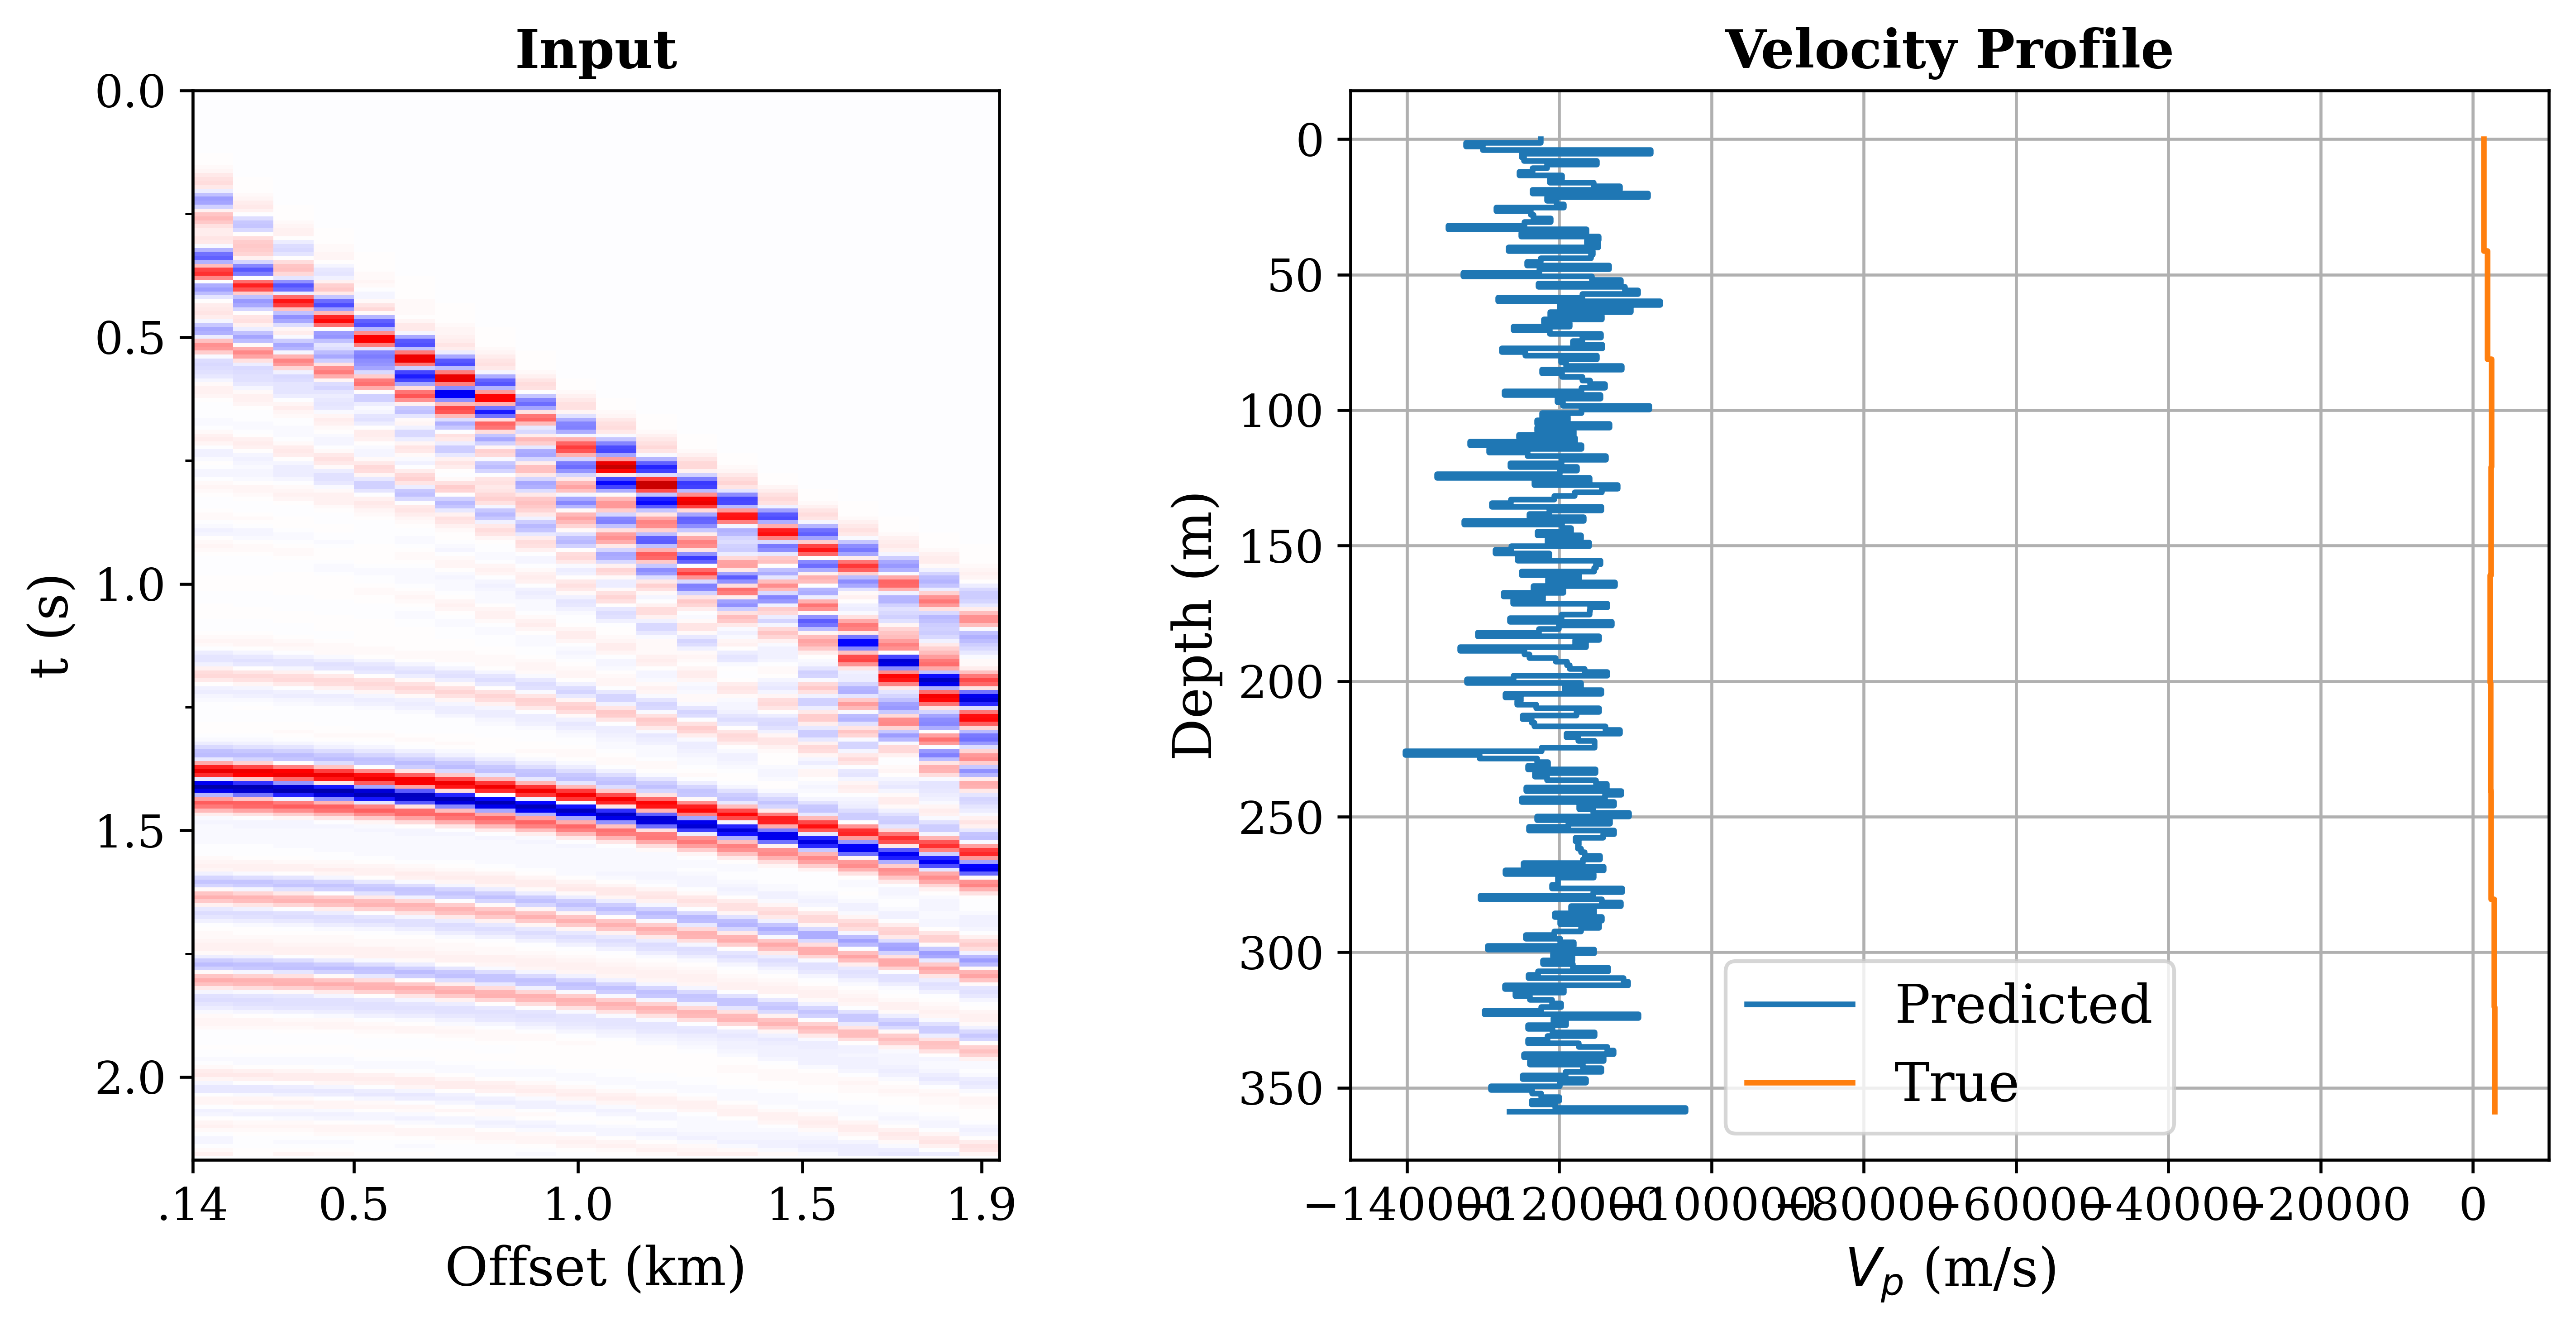

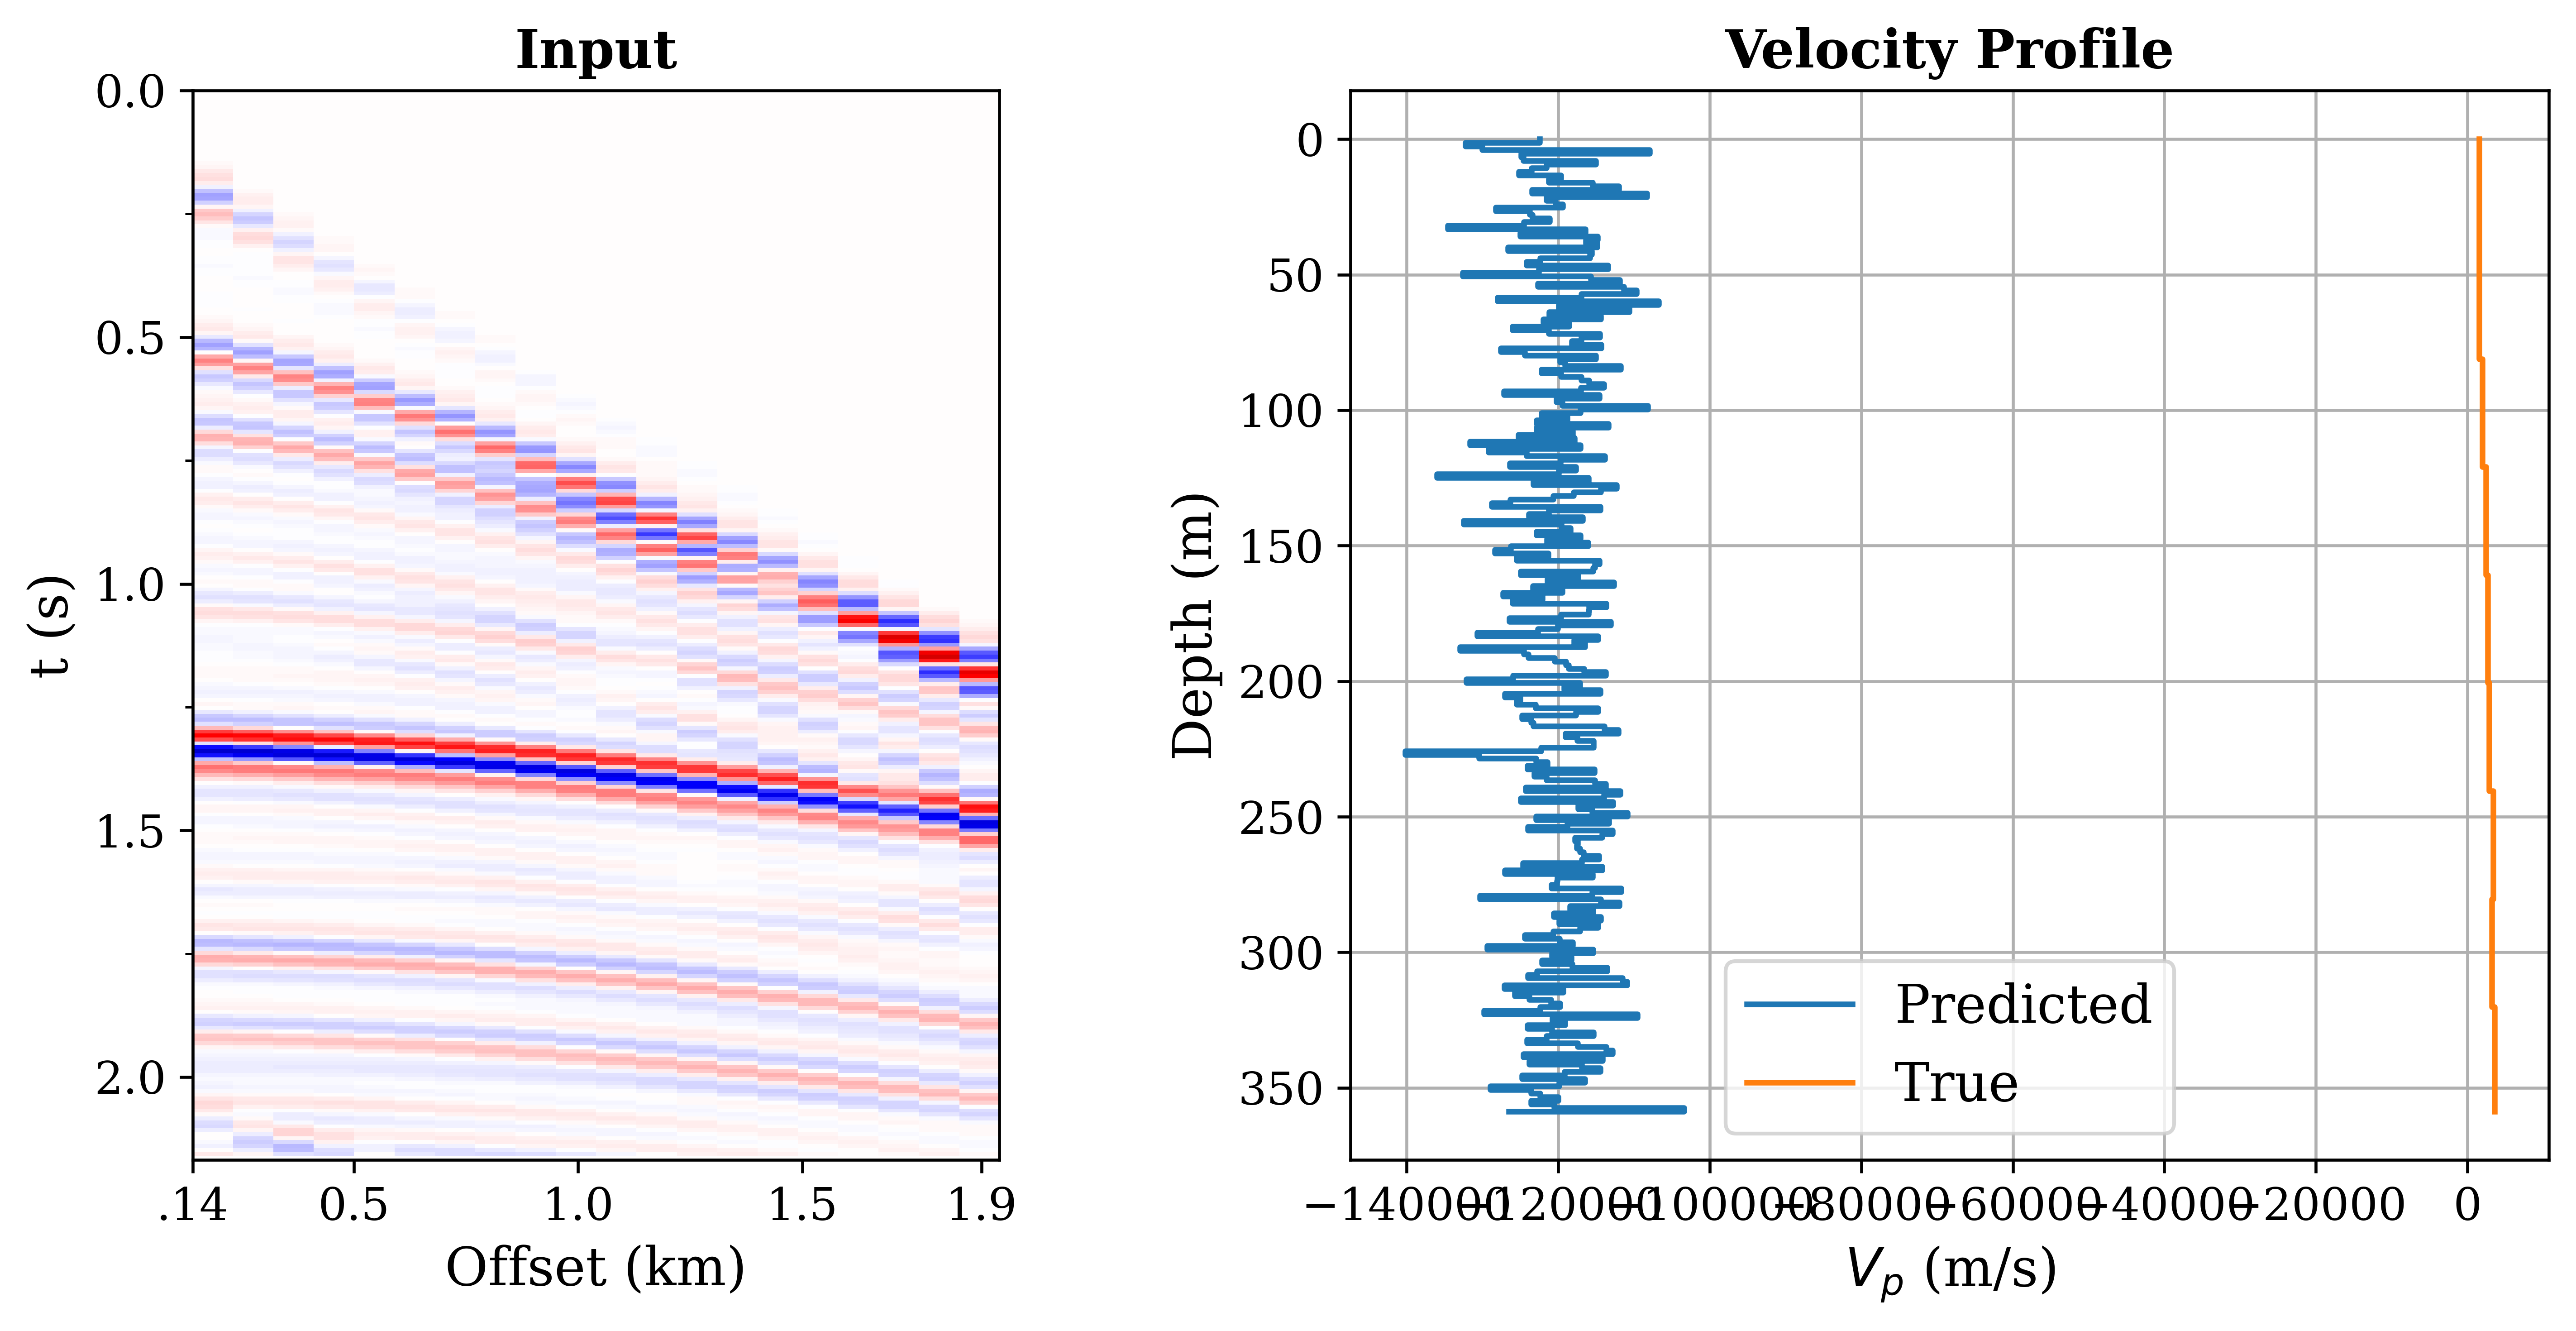

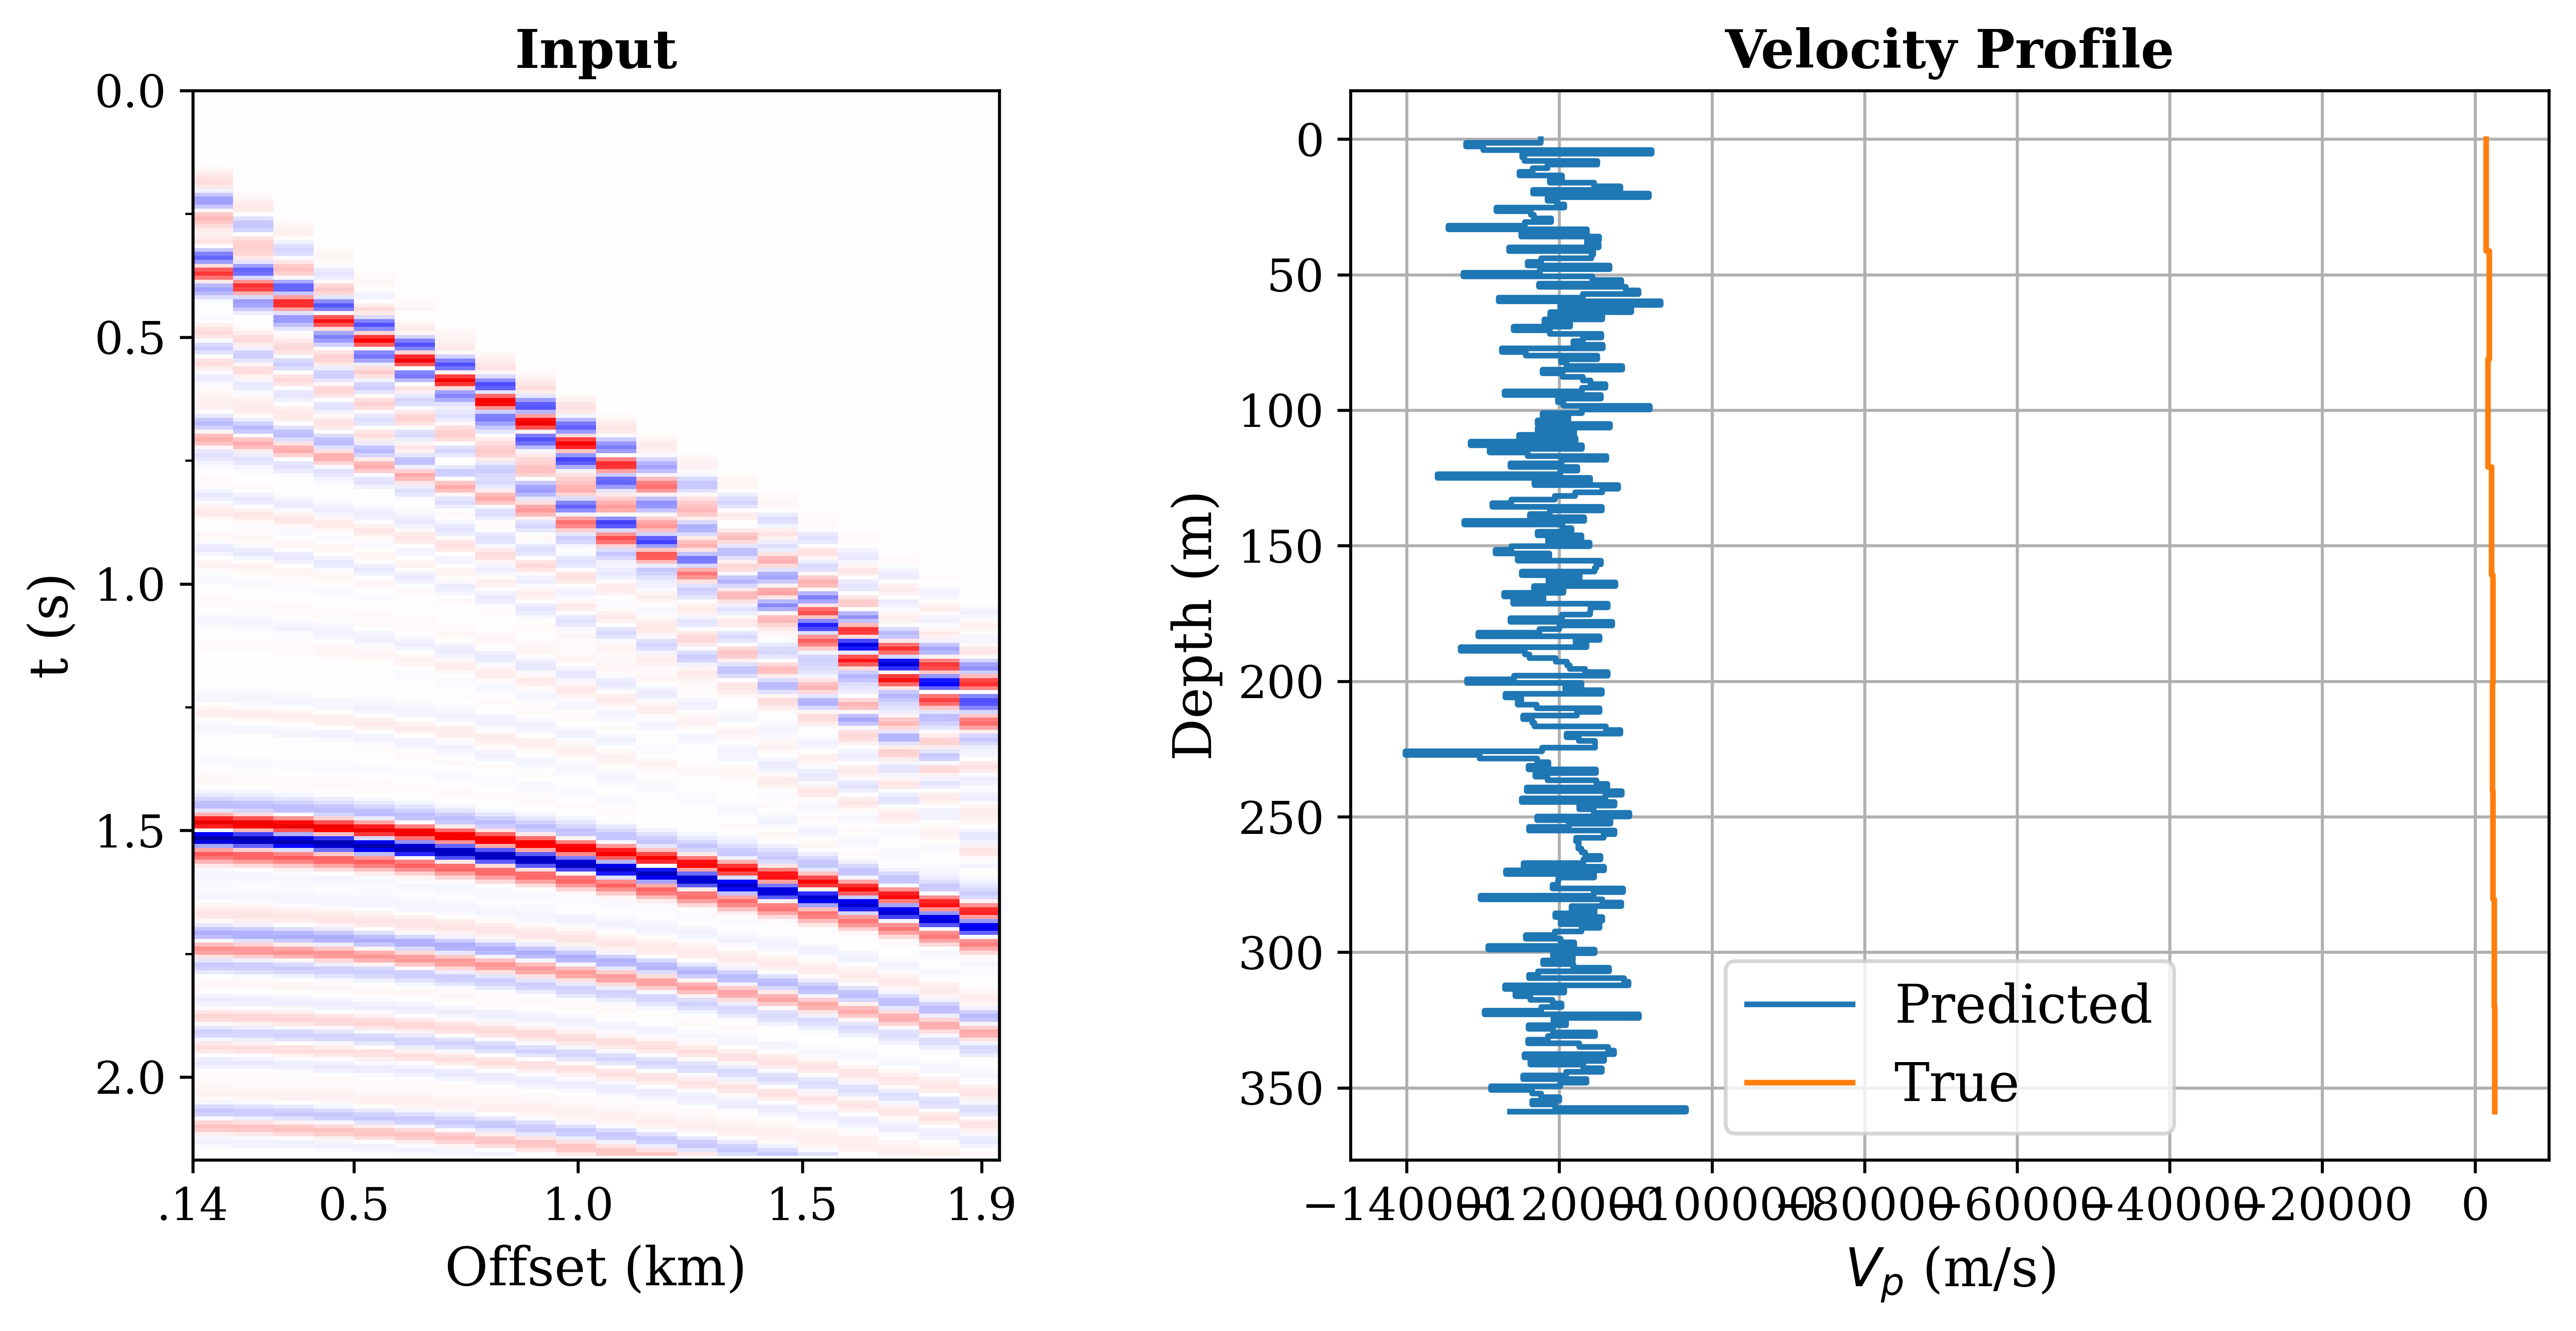

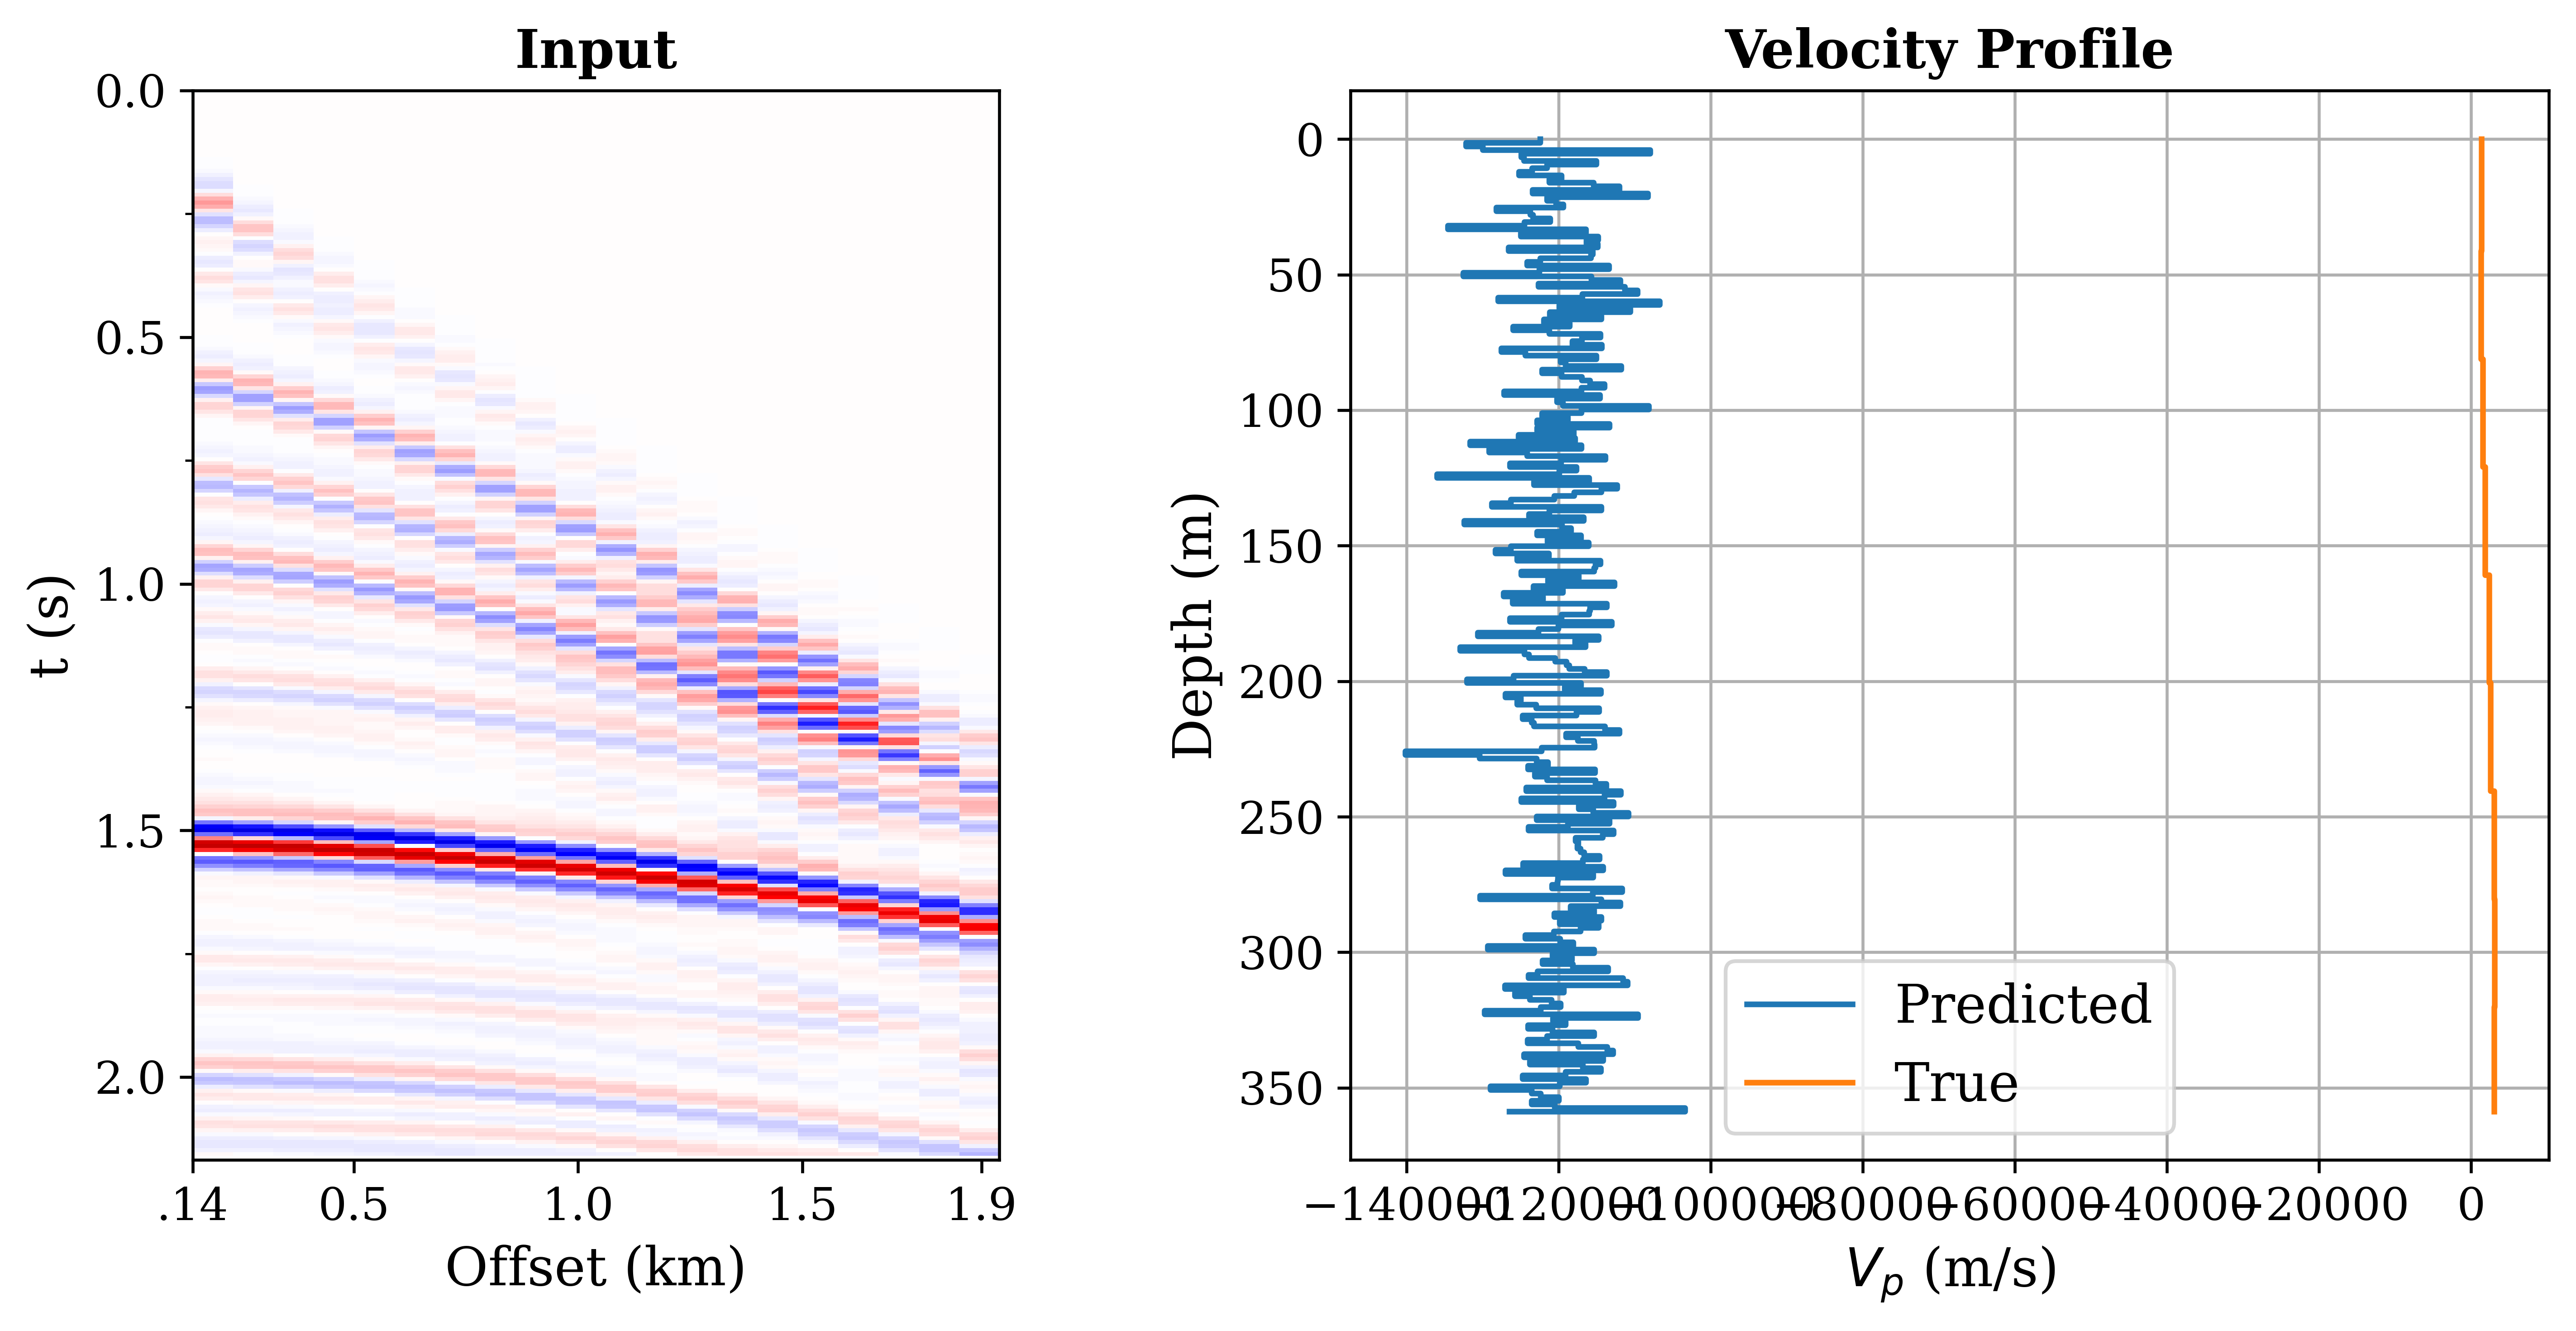

In [17]:
# First, set up matplotlib for notebook display
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]  # Make figures a bit larger

model.eval()

idx = torch.randint(len(test_data), (4,))
print(idx)

inputs_embeds = test_data.encodings['labels'][idx]
labels = F.interpolate(test_data.encodings['vel'][idx].unsqueeze(0).unsqueeze(0), 
                      size=(len(test_data.encodings['vel'][idx]), 271), 
                      mode='nearest')
labels = labels.squeeze()

with torch.no_grad():
    # Apply the projection before passing to model
    inputs_embeds_256 = projection(inputs_embeds.to(device))
    sample_output = model(inputs_embeds=inputs_embeds_256)
    

# Create a figure for each sample
for X, y, z in zip(inputs_embeds.cpu(), sample_output.logits.cpu(), labels):
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(1 * (X - X.mean()).detach().swapaxes(0, 1) * 1, aspect=1.1, vmin=-1, vmax=1, cmap='seismic', 
                 extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[0].set_title("Input", fontsize=14)
    ax[0].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[0].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[0].set_yticks(np.arange(0, 2.5, 0.5))
    ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[0].set_ylabel("t (s)")
    ax[0].set_xlabel("Offset (km)")
    ax[1].step(y, np.arange(0, 40*9, 40*9/(271)), label="Predicted")
    ax[1].step(z, np.arange(0, 40*9, 40*9/(271)), label="True")
    ax[1].invert_yaxis()
    ax[1].grid()
    ax[1].legend()
    ax[1].set_ylabel("Depth")
    ax[1].set_xlabel("$V_p$ (m/s)")
    ax[1].set_ylabel("Depth (m)")
    ax[1].set_title("Velocity Profile", fontsize=14)
    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()  # Explicitly show the plot



In [ ]:
with torch.no_grad():
    # Apply the projection before passing to model
    inputs_embeds_256 = projection(inputs_embeds.to(device))
    sample_output = model(inputs_embeds=inputs_embeds_256)
    
# Display information about the logits
print("Sample output logits shape:", sample_output.logits.cpu().shape)
print("Sample output logits statistics:")
print(f"  Min: {sample_output.logits.cpu().min().item():.4f}")
print(f"  Max: {sample_output.logits.cpu().max().item():.4f}")
print(f"  Mean: {sample_output.logits.cpu().mean().item():.4f}")
print(f"  Std: {sample_output.logits.cpu().std().item():.4f}")
print("\nFirst few values of the first sample:")
print(sample_output.logits.cpu()[0, :10])  # Print first 10 values of first sample


## Finalize

In [ ]:
# Save everything
print("Saving to", config.parent_dir)
if os.path.exists(os.path.join(config.parent_dir, 'model.pt')):
    if input("Path exists. Overwrite? (y/n)") == 'y':
        torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
        avg_train_loss_arr = np.array(avg_train_loss)
        avg_valid_loss_arr = np.array(avg_valid_loss)
        np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
        np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
        torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
        print("Saved successfully to", config.parent_dir)
    else:
        print("Saving failed.")
else:
    torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
    avg_train_loss_arr = np.array(avg_train_loss)
    avg_valid_loss_arr = np.array(avg_valid_loss)
    np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
    np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
    torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
    print("Saved successfully to", config.parent_dir)